# 분류 모델 - Optuna를 활용한 하이퍼파라미터 최적화

## 학습 목표
1. **Optuna**를 사용하여 분류 모델의 하이퍼파라미터를 자동으로 최적화할 수 있다
2. **기본 분류기**(LogisticRegression, SVC, KNN, DecisionTree)를 Optuna로 튜닝할 수 있다
3. **앙상블 분류기**(RandomForest, XGBoost, LightGBM)를 Optuna로 튜닝할 수 있다
4. **분류 평가 지표**(Accuracy, Precision, Recall, F1-score)를 활용하여 모델을 평가할 수 있다

## 주요 내용
- Breast Cancer 데이터셋 활용 (이진 분류)
- 기본 분류기 최적화: LogisticRegression, SVC, KNN, DecisionTree
- 앙상블 분류기 최적화: RandomForest, XGBoost, LightGBM
- 혼동 행렬 및 분류 리포트 분석

## 1. 환경 설정 및 데이터 로드

In [1]:
#%pip install optuna xgboost lightgbm

In [2]:
# 필요한 라이브러리 설치 (필요시)
# !pip install optuna xgboost lightgbm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Optuna
import optuna
from optuna.samplers import TPESampler

# Scikit-learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)

# 기본 분류기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# 앙상블 분류기
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# XGBoost, LightGBM
try:
    from xgboost import XGBClassifier
    print("XGBoost loaded successfully")
except ImportError:
    print("XGBoost not installed. Run: pip install xgboost")

try:
    from lightgbm import LGBMClassifier
    print("LightGBM loaded successfully")
except ImportError:
    print("LightGBM not installed. Run: pip install lightgbm")

print(f"\nOptuna version: {optuna.__version__}")

XGBoost loaded successfully
LightGBM loaded successfully

Optuna version: 4.6.0


In [3]:
# Breast Cancer 데이터셋 로드 (이진 분류)
cancer = load_breast_cancer()

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

print(f"데이터 shape: {X.shape}")
print(f"타겟 shape: {y.shape}")
print(f"\n클래스 분포:")
print(f"  0 (악성): {(y == 0).sum()}")
print(f"  1 (양성): {(y == 1).sum()}")
X.head()

데이터 shape: (569, 30)
타겟 shape: (569,)

클래스 분포:
  0 (악성): 212
  1 (양성): 357


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"학습 데이터: {X_train_scaled.shape}")
print(f"테스트 데이터: {X_test_scaled.shape}")

학습 데이터: (455, 30)
테스트 데이터: (114, 30)


## 2. 평가 함수 정의

In [5]:
# 결과 저장용 DataFrame
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

def evaluate_classifier(model_name, model, X_test, y_true, y_pred):
    """분류 모델 평가 및 결과 저장"""
    global results_df
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # AUC 계산 (predict_proba가 있는 경우)
    try:
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_true, y_prob)
        else:
            auc = np.nan
    except:
        auc = np.nan
    
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1],
        'AUC': [auc]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  AUC:       {auc:.4f}" if not np.isnan(auc) else "  AUC:       N/A")
    
    return f1

---
# Part 1: 기본 분류기 최적화
---

In [6]:
import optuna
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 1. 목적 함수 정의 (데이터 로드 포함)
def objective(trial):
    # 데이터 준비
    iris = load_iris()
    X_train, X_valid, y_train, y_valid = train_test_split(iris.data, iris.target, test_size=0.2)

    # 하이퍼파라미터 탐색 범위 설정
    # 정수형(int), 범주형(categorical) 파라미터 정의
    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"])
    }

    # 모델 학습
    model = DecisionTreeClassifier(**param)
    model.fit(X_train, y_train)

    # 예측 및 검증 (목표값 산출)
    preds = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    
    return accuracy

# 2. 최적화 실행
study = optuna.create_study(direction="maximize") # 정확도이므로 maximize
study.optimize(objective, n_trials=50)

# 3. 결과 요약
print(f"Best Accuracy: {study.best_value}")
print(f"Best Hyperparameters: {study.best_params}")

[I 2026-01-14 07:31:54,957] A new study created in memory with name: no-name-37e3357a-d938-41e4-b472-c8fef1bbf6d5
[I 2026-01-14 07:31:54,962] Trial 0 finished with value: 0.9333333333333333 and parameters: {'max_depth': 17, 'min_samples_split': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9333333333333333.
[I 2026-01-14 07:31:54,966] Trial 1 finished with value: 0.9 and parameters: {'max_depth': 16, 'min_samples_split': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.9333333333333333.
[I 2026-01-14 07:31:54,969] Trial 2 finished with value: 0.9666666666666667 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'criterion': 'gini'}. Best is trial 2 with value: 0.9666666666666667.
[I 2026-01-14 07:31:54,974] Trial 3 finished with value: 0.9666666666666667 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'criterion': 'gini'}. Best is trial 2 with value: 0.9666666666666667.
[I 2026-01-14 07:31:54,977] Trial 4 finished with value: 0.9666666666666667 and p

Best Accuracy: 1.0
Best Hyperparameters: {'max_depth': 16, 'min_samples_split': 6, 'criterion': 'gini'}


## 3. LogisticRegression + Optuna

In [7]:
def objective_lr(trial):
    """LogisticRegression의 objective 함수"""
    params = {
        'C': trial.suggest_float('C', 1e-4, 100, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': 'saga',  # l1, l2 모두 지원
        'max_iter': 1000,
        'random_state': 42
    }
    
    model = LogisticRegression(**params)
    
    # Stratified K-Fold 교차 검증
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    return scores.mean()

print("=" * 50)
print("LogisticRegression 최적화 시작...")
print("=" * 50)

sampler = TPESampler(seed=42)
study_lr = optuna.create_study(direction='maximize', sampler=sampler)
study_lr.optimize(objective_lr, n_trials=50, show_progress_bar=True)

print(f"\n최적 파라미터: {study_lr.best_params}")
print(f"최적 F1 (CV): {study_lr.best_value:.4f}")

[I 2026-01-14 07:31:55,214] A new study created in memory with name: no-name-07938cb8-e7c9-4ff2-8e78-c30dd80975b8


LogisticRegression 최적화 시작...


Best trial: 0. Best value: 0.937984:   2%|▏         | 1/50 [00:00<00:11,  4.31it/s]

[I 2026-01-14 07:31:55,445] Trial 0 finished with value: 0.9379837018428117 and parameters: {'C': 0.017670169402947963, 'penalty': 'l1'}. Best is trial 0 with value: 0.9379837018428117.


Best trial: 1. Best value: 0.977264:   4%|▍         | 2/50 [00:00<00:18,  2.64it/s]

[I 2026-01-14 07:31:55,926] Trial 1 finished with value: 0.9772636440599827 and parameters: {'C': 0.39079671568228835, 'penalty': 'l1'}. Best is trial 1 with value: 0.9772636440599827.
[I 2026-01-14 07:31:55,941] Trial 2 finished with value: 0.7702702702702703 and parameters: {'C': 0.00022310108018679258, 'penalty': 'l1'}. Best is trial 1 with value: 0.9772636440599827.


Best trial: 3. Best value: 0.977267:   8%|▊         | 4/50 [00:01<00:11,  4.10it/s]

[I 2026-01-14 07:31:56,253] Trial 3 finished with value: 0.9772671279637312 and parameters: {'C': 1.7718847354806828, 'penalty': 'l2'}. Best is trial 3 with value: 0.9772671279637312.


Best trial: 6. Best value: 0.977687:  14%|█▍        | 7/50 [00:01<00:14,  3.05it/s]

[I 2026-01-14 07:31:56,769] Trial 4 finished with value: 0.9704905569739106 and parameters: {'C': 9.877700294007917, 'penalty': 'l1'}. Best is trial 3 with value: 0.9772671279637312.
[I 2026-01-14 07:31:56,795] Trial 5 finished with value: 0.9210722811941456 and parameters: {'C': 0.0012601639723276807, 'penalty': 'l2'}. Best is trial 3 with value: 0.9772671279637312.
[I 2026-01-14 07:31:56,836] Trial 6 finished with value: 0.9776873362536463 and parameters: {'C': 0.039054412752107935, 'penalty': 'l2'}. Best is trial 6 with value: 0.9776873362536463.
[I 2026-01-14 07:31:56,860] Trial 7 finished with value: 0.8975505634314794 and parameters: {'C': 0.0006870101665590031, 'penalty': 'l2'}. Best is trial 6 with value: 0.9776873362536463.


Best trial: 6. Best value: 0.977687:  18%|█▊        | 9/50 [00:01<00:07,  5.30it/s]

[I 2026-01-14 07:31:57,208] Trial 8 finished with value: 0.9660118039541687 and parameters: {'C': 0.054502936945582565, 'penalty': 'l1'}. Best is trial 6 with value: 0.9776873362536463.


Best trial: 6. Best value: 0.977687:  20%|██        | 10/50 [00:02<00:09,  4.14it/s]

[I 2026-01-14 07:31:57,680] Trial 9 finished with value: 0.9691398016538747 and parameters: {'C': 0.12173252504194051, 'penalty': 'l1'}. Best is trial 6 with value: 0.9776873362536463.


Best trial: 6. Best value: 0.977687:  22%|██▏       | 11/50 [00:02<00:10,  3.71it/s]

[I 2026-01-14 07:31:58,057] Trial 10 finished with value: 0.9686574343443277 and parameters: {'C': 46.86183228417077, 'penalty': 'l2'}. Best is trial 6 with value: 0.9776873362536463.


Best trial: 11. Best value: 0.978975:  24%|██▍       | 12/50 [00:03<00:10,  3.67it/s]

[I 2026-01-14 07:31:58,337] Trial 11 finished with value: 0.978974937310106 and parameters: {'C': 1.547982470266329, 'penalty': 'l2'}. Best is trial 11 with value: 0.978974937310106.
[I 2026-01-14 07:31:58,369] Trial 12 finished with value: 0.9629639287266405 and parameters: {'C': 0.00976573840579118, 'penalty': 'l2'}. Best is trial 11 with value: 0.978974937310106.


Best trial: 11. Best value: 0.978975:  28%|██▊       | 14/50 [00:03<00:08,  4.47it/s]

[I 2026-01-14 07:31:58,638] Trial 13 finished with value: 0.978974937310106 and parameters: {'C': 1.4501439981623072, 'penalty': 'l2'}. Best is trial 11 with value: 0.978974937310106.


Best trial: 11. Best value: 0.978975:  30%|███       | 15/50 [00:03<00:09,  3.89it/s]

[I 2026-01-14 07:31:59,013] Trial 14 finished with value: 0.9772671279637312 and parameters: {'C': 2.9374155980789554, 'penalty': 'l2'}. Best is trial 11 with value: 0.978974937310106.


Best trial: 11. Best value: 0.978975:  32%|███▏      | 16/50 [00:04<00:09,  3.50it/s]

[I 2026-01-14 07:31:59,389] Trial 15 finished with value: 0.9686574343443277 and parameters: {'C': 81.87538577546877, 'penalty': 'l2'}. Best is trial 11 with value: 0.978974937310106.


Best trial: 18. Best value: 0.984255:  38%|███▊      | 19/50 [00:04<00:05,  5.32it/s]

[I 2026-01-14 07:31:59,574] Trial 16 finished with value: 0.9808927906007445 and parameters: {'C': 0.8473878289822423, 'penalty': 'l2'}. Best is trial 16 with value: 0.9808927906007445.
[I 2026-01-14 07:31:59,664] Trial 17 finished with value: 0.982485315330225 and parameters: {'C': 0.28167303570609975, 'penalty': 'l2'}. Best is trial 17 with value: 0.982485315330225.
[I 2026-01-14 07:31:59,753] Trial 18 finished with value: 0.984254956825267 and parameters: {'C': 0.27526174955283095, 'penalty': 'l2'}. Best is trial 18 with value: 0.984254956825267.


Best trial: 20. Best value: 0.986056:  42%|████▏     | 21/50 [00:04<00:03,  7.28it/s]

[I 2026-01-14 07:31:59,781] Trial 19 finished with value: 0.9516424259402478 and parameters: {'C': 0.003998954268898133, 'penalty': 'l2'}. Best is trial 18 with value: 0.984254956825267.
[I 2026-01-14 07:31:59,861] Trial 20 finished with value: 0.9860559194087166 and parameters: {'C': 0.2299512560199053, 'penalty': 'l2'}. Best is trial 20 with value: 0.9860559194087166.
[I 2026-01-14 07:31:59,951] Trial 21 finished with value: 0.982485315330225 and parameters: {'C': 0.28549742068171596, 'penalty': 'l2'}. Best is trial 20 with value: 0.9860559194087166.


Best trial: 23. Best value: 0.986116:  50%|█████     | 25/50 [00:04<00:02, 10.37it/s]

[I 2026-01-14 07:32:00,021] Trial 22 finished with value: 0.9860559194087166 and parameters: {'C': 0.1728704015593456, 'penalty': 'l2'}. Best is trial 20 with value: 0.9860559194087166.
[I 2026-01-14 07:32:00,078] Trial 23 finished with value: 0.9861164154764722 and parameters: {'C': 0.10853645713672012, 'penalty': 'l2'}. Best is trial 23 with value: 0.9861164154764722.
[I 2026-01-14 07:32:00,129] Trial 24 finished with value: 0.9844077961019491 and parameters: {'C': 0.07934294669977417, 'penalty': 'l2'}. Best is trial 23 with value: 0.9861164154764722.


Best trial: 28. Best value: 0.987826:  56%|█████▌    | 28/50 [00:05<00:02,  7.56it/s]

[I 2026-01-14 07:32:00,508] Trial 25 finished with value: 0.9719859994814624 and parameters: {'C': 6.302825766939485, 'penalty': 'l2'}. Best is trial 23 with value: 0.9861164154764722.
[I 2026-01-14 07:32:00,544] Trial 26 finished with value: 0.9661572060375649 and parameters: {'C': 0.015366610312239517, 'penalty': 'l2'}. Best is trial 23 with value: 0.9861164154764722.
[I 2026-01-14 07:32:00,572] Trial 27 finished with value: 0.9516424259402478 and parameters: {'C': 0.003780571784493473, 'penalty': 'l2'}. Best is trial 23 with value: 0.9861164154764722.
[I 2026-01-14 07:32:00,631] Trial 28 finished with value: 0.9878255609037587 and parameters: {'C': 0.12338598610657582, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.


Best trial: 28. Best value: 0.987826:  62%|██████▏   | 31/50 [00:05<00:02,  8.10it/s]

[I 2026-01-14 07:32:00,876] Trial 29 finished with value: 0.9517375754889021 and parameters: {'C': 0.025377127999193498, 'penalty': 'l1'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:00,909] Trial 30 finished with value: 0.9581185245764237 and parameters: {'C': 0.006290023075183988, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:00,970] Trial 31 finished with value: 0.9878255609037587 and parameters: {'C': 0.13579107671856774, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.


Best trial: 28. Best value: 0.987826:  66%|██████▌   | 33/50 [00:05<00:01,  8.97it/s]

[I 2026-01-14 07:32:01,148] Trial 32 finished with value: 0.9808927906007445 and parameters: {'C': 0.8080365328340258, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:01,213] Trial 33 finished with value: 0.9878255609037587 and parameters: {'C': 0.13927404827387982, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.


Best trial: 28. Best value: 0.987826:  72%|███████▏  | 36/50 [00:06<00:01,  7.16it/s]

[I 2026-01-14 07:32:01,587] Trial 34 finished with value: 0.9709094431489167 and parameters: {'C': 0.0677873999679497, 'penalty': 'l1'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:01,728] Trial 35 finished with value: 0.9825442464894886 and parameters: {'C': 0.5561642187777794, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.


Best trial: 28. Best value: 0.987826:  78%|███████▊  | 39/50 [00:06<00:01,  8.48it/s]

[I 2026-01-14 07:32:01,941] Trial 36 finished with value: 0.9443445366936312 and parameters: {'C': 0.021367215393682814, 'penalty': 'l1'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:01,999] Trial 37 finished with value: 0.9861164154764722 and parameters: {'C': 0.10464423857326344, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:02,042] Trial 38 finished with value: 0.9776873362536463 and parameters: {'C': 0.04053723819108041, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:02,068] Trial 39 finished with value: 0.7895432193377399 and parameters: {'C': 0.0001544886172286893, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.


Best trial: 28. Best value: 0.987826:  86%|████████▌ | 43/50 [00:07<00:00,  7.81it/s]

[I 2026-01-14 07:32:02,554] Trial 40 finished with value: 0.9754626814765329 and parameters: {'C': 0.4460400230574016, 'penalty': 'l1'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:02,618] Trial 41 finished with value: 0.9878255609037587 and parameters: {'C': 0.13825655845411208, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:02,660] Trial 42 finished with value: 0.9776873362536463 and parameters: {'C': 0.038529220540233985, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:02,721] Trial 43 finished with value: 0.9878255609037587 and parameters: {'C': 0.12681232201123943, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.


Best trial: 28. Best value: 0.987826:  90%|█████████ | 45/50 [00:07<00:00,  9.26it/s]

[I 2026-01-14 07:32:02,788] Trial 44 finished with value: 0.9878255609037587 and parameters: {'C': 0.15587335383365605, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:02,960] Trial 45 finished with value: 0.9808927906007445 and parameters: {'C': 0.7671198065755442, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.


Best trial: 28. Best value: 0.987826:  94%|█████████▍| 47/50 [00:08<00:00,  6.39it/s]

[I 2026-01-14 07:32:03,318] Trial 46 finished with value: 0.9772671279637312 and parameters: {'C': 2.240746358920166, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:03,356] Trial 47 finished with value: 0.9645605673821027 and parameters: {'C': 0.014528971563209082, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.


Best trial: 28. Best value: 0.987826: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]

[I 2026-01-14 07:32:03,717] Trial 48 finished with value: 0.9692869601705014 and parameters: {'C': 0.061809594150683655, 'penalty': 'l1'}. Best is trial 28 with value: 0.9878255609037587.
[I 2026-01-14 07:32:03,744] Trial 49 finished with value: 0.9256289158405625 and parameters: {'C': 0.0015084915140947982, 'penalty': 'l2'}. Best is trial 28 with value: 0.9878255609037587.

최적 파라미터: {'C': 0.12338598610657582, 'penalty': 'l2'}
최적 F1 (CV): 0.9878


In [8]:
# 최적 LogisticRegression 모델 평가
best_lr = LogisticRegression(**study_lr.best_params, solver='saga', max_iter=1000, random_state=42)
best_lr.fit(X_train_scaled, y_train)
pred_lr = best_lr.predict(X_test_scaled)

evaluate_classifier('LogisticRegression', best_lr, X_test_scaled, y_test, pred_lr)


LogisticRegression:
  Accuracy:  0.9737
  Precision: 0.9726
  Recall:    0.9861
  F1-score:  0.9793
  AUC:       0.9957


0.9793103448275862

## 4. SVC + Optuna

In [9]:
def objective_svc(trial):
    """SVC의 objective 함수"""
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    
    params = {
        'C': trial.suggest_float('C', 1e-2, 100, log=True),
        'kernel': kernel,
        'probability': True,
        'random_state': 42
    }
    
    if kernel == 'rbf':
        params['gamma'] = trial.suggest_categorical('gamma', ['scale', 'auto'])
    elif kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)
    
    model = SVC(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    return scores.mean()

print("=" * 50)
print("SVC 최적화 시작...")
print("=" * 50)

sampler = TPESampler(seed=42)
study_svc = optuna.create_study(direction='maximize', sampler=sampler)
study_svc.optimize(objective_svc, n_trials=50, show_progress_bar=True)

print(f"\n최적 파라미터: {study_svc.best_params}")
print(f"최적 F1 (CV): {study_svc.best_value:.4f}")

[I 2026-01-14 07:32:03,780] A new study created in memory with name: no-name-9467eee7-77e2-4d1f-ad95-b63e33cac614


SVC 최적화 시작...


Best trial: 1. Best value: 0.977202:   4%|▍         | 2/50 [00:00<00:02, 19.08it/s]

[I 2026-01-14 07:32:03,832] Trial 0 finished with value: 0.9737821839995753 and parameters: {'kernel': 'rbf', 'C': 2.481040974867813, 'gamma': 'scale'}. Best is trial 0 with value: 0.9737821839995753.
[I 2026-01-14 07:32:03,882] Trial 1 finished with value: 0.9772017562647248 and parameters: {'kernel': 'rbf', 'C': 6.79657809075816, 'gamma': 'auto'}. Best is trial 1 with value: 0.9772017562647248.


Best trial: 2. Best value: 0.979453:   4%|▍         | 2/50 [00:00<00:02, 19.08it/s]

[I 2026-01-14 07:32:03,916] Trial 2 finished with value: 0.9794527106194802 and parameters: {'kernel': 'linear', 'C': 0.05415244119402541}. Best is trial 2 with value: 0.9794527106194802.


Best trial: 2. Best value: 0.979453:   8%|▊         | 4/50 [00:00<00:02, 18.76it/s]

[I 2026-01-14 07:32:03,993] Trial 3 finished with value: 0.9606225483520735 and parameters: {'kernel': 'rbf', 'C': 0.14618962793704965, 'gamma': 'scale'}. Best is trial 2 with value: 0.9794527106194802.


Best trial: 2. Best value: 0.979453:   8%|▊         | 4/50 [00:00<00:02, 18.76it/s]

[I 2026-01-14 07:32:04,083] Trial 4 finished with value: 0.8940006819368735 and parameters: {'kernel': 'poly', 'C': 13.826232179369875, 'degree': 2}. Best is trial 2 with value: 0.9794527106194802.


Best trial: 2. Best value: 0.979453:  12%|█▏        | 6/50 [00:00<00:02, 16.32it/s]

[I 2026-01-14 07:32:04,133] Trial 5 finished with value: 0.9737821839995753 and parameters: {'kernel': 'rbf', 'C': 2.69264691008618, 'gamma': 'scale'}. Best is trial 2 with value: 0.9794527106194802.


Best trial: 2. Best value: 0.979453:  12%|█▏        | 6/50 [00:00<00:02, 16.32it/s]

[I 2026-01-14 07:32:04,206] Trial 6 finished with value: 0.9638954881533592 and parameters: {'kernel': 'rbf', 'C': 0.1653693718282443, 'gamma': 'auto'}. Best is trial 2 with value: 0.9794527106194802.


Best trial: 2. Best value: 0.979453:  16%|█▌        | 8/50 [00:00<00:02, 15.50it/s]

[I 2026-01-14 07:32:04,274] Trial 7 finished with value: 0.8127379060084342 and parameters: {'kernel': 'poly', 'C': 0.013726318898045875, 'degree': 5}. Best is trial 2 with value: 0.9794527106194802.


Best trial: 2. Best value: 0.979453:  16%|█▌        | 8/50 [00:00<00:02, 15.50it/s]

[I 2026-01-14 07:32:04,327] Trial 8 finished with value: 0.9756153066291582 and parameters: {'kernel': 'rbf', 'C': 1.2030178871154673, 'gamma': 'scale'}. Best is trial 2 with value: 0.9794527106194802.


Best trial: 2. Best value: 0.979453:  20%|██        | 10/50 [00:00<00:02, 15.51it/s]

[I 2026-01-14 07:32:04,401] Trial 9 finished with value: 0.9613897016185347 and parameters: {'kernel': 'linear', 'C': 37.95853142670641}. Best is trial 2 with value: 0.9794527106194802.
[I 2026-01-14 07:32:04,437] Trial 10 finished with value: 0.9777765224297891 and parameters: {'kernel': 'linear', 'C': 0.010567900894501657}. Best is trial 2 with value: 0.9794527106194802.


Best trial: 12. Best value: 0.982785:  26%|██▌       | 13/50 [00:00<00:01, 19.47it/s]

[I 2026-01-14 07:32:04,474] Trial 11 finished with value: 0.9777765224297891 and parameters: {'kernel': 'linear', 'C': 0.010499980275967127}. Best is trial 2 with value: 0.9794527106194802.
[I 2026-01-14 07:32:04,505] Trial 12 finished with value: 0.9827850303215921 and parameters: {'kernel': 'linear', 'C': 0.07142429518469544}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  28%|██▊       | 14/50 [00:00<00:01, 19.47it/s]

[I 2026-01-14 07:32:04,538] Trial 13 finished with value: 0.9776255583180756 and parameters: {'kernel': 'linear', 'C': 0.12206944879845172}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:04,569] Trial 14 finished with value: 0.9794527106194802 and parameters: {'kernel': 'linear', 'C': 0.050521179297115894}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  34%|███▍      | 17/50 [00:00<00:01, 23.36it/s]

[I 2026-01-14 07:32:04,603] Trial 15 finished with value: 0.9721709988042774 and parameters: {'kernel': 'linear', 'C': 0.42550070101302573}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:04,635] Trial 16 finished with value: 0.9810764109470689 and parameters: {'kernel': 'linear', 'C': 0.03932010872350958}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  34%|███▍      | 17/50 [00:00<00:01, 23.36it/s]

[I 2026-01-14 07:32:04,668] Trial 17 finished with value: 0.9794527106194802 and parameters: {'kernel': 'linear', 'C': 0.03046144539032241}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  40%|████      | 20/50 [00:00<00:01, 22.74it/s]

[I 2026-01-14 07:32:04,740] Trial 18 finished with value: 0.8494294848493322 and parameters: {'kernel': 'poly', 'C': 0.3200179106336629, 'degree': 2}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:04,773] Trial 19 finished with value: 0.9721709988042774 and parameters: {'kernel': 'linear', 'C': 0.589100540226894}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  42%|████▏     | 21/50 [00:01<00:01, 22.74it/s]

[I 2026-01-14 07:32:04,806] Trial 20 finished with value: 0.9794527106194802 and parameters: {'kernel': 'linear', 'C': 0.030060489121091553}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:04,838] Trial 21 finished with value: 0.9794527106194802 and parameters: {'kernel': 'linear', 'C': 0.04570714119815694}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  48%|████▊     | 24/50 [00:01<00:01, 25.43it/s]

[I 2026-01-14 07:32:04,869] Trial 22 finished with value: 0.9810153888265501 and parameters: {'kernel': 'linear', 'C': 0.08682721813478511}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:04,902] Trial 23 finished with value: 0.9827850303215921 and parameters: {'kernel': 'linear', 'C': 0.09647283293578432}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  48%|████▊     | 24/50 [00:01<00:01, 25.43it/s]

[I 2026-01-14 07:32:04,935] Trial 24 finished with value: 0.9758902599982061 and parameters: {'kernel': 'linear', 'C': 0.22048949840732748}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  54%|█████▍    | 27/50 [00:01<00:00, 24.48it/s]

[I 2026-01-14 07:32:05,003] Trial 25 finished with value: 0.8138766533863185 and parameters: {'kernel': 'poly', 'C': 0.019325057537219397, 'degree': 5}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,035] Trial 26 finished with value: 0.9827850303215921 and parameters: {'kernel': 'linear', 'C': 0.07868553528824854}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  56%|█████▌    | 28/50 [00:01<00:00, 24.48it/s]

[I 2026-01-14 07:32:05,066] Trial 27 finished with value: 0.9827850303215921 and parameters: {'kernel': 'linear', 'C': 0.07637530205627753}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,102] Trial 28 finished with value: 0.972288320366518 and parameters: {'kernel': 'linear', 'C': 0.7134682835447501}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  60%|██████    | 30/50 [00:01<00:00, 23.43it/s]

[I 2026-01-14 07:32:05,176] Trial 29 finished with value: 0.8588332231969922 and parameters: {'kernel': 'poly', 'C': 1.3319751466656047, 'degree': 4}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  60%|██████    | 30/50 [00:01<00:00, 23.43it/s]

[I 2026-01-14 07:32:05,211] Trial 30 finished with value: 0.9775112443778111 and parameters: {'kernel': 'linear', 'C': 0.24976604396113805}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  68%|██████▊   | 34/50 [00:01<00:00, 25.65it/s]

[I 2026-01-14 07:32:05,243] Trial 31 finished with value: 0.9792480412964908 and parameters: {'kernel': 'linear', 'C': 0.10087264244805895}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,274] Trial 32 finished with value: 0.9827850303215921 and parameters: {'kernel': 'linear', 'C': 0.07968861015319495}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,307] Trial 33 finished with value: 0.9778560719640179 and parameters: {'kernel': 'linear', 'C': 0.0210574883967291}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,339] Trial 34 finished with value: 0.9794527106194802 and parameters: {'kernel': 'linear', 'C': 0.05684046198054645}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  70%|███████   | 35/50 [00:01<00:00, 25.65it/s]

[I 2026-01-14 07:32:05,412] Trial 35 finished with value: 0.9638954881533592 and parameters: {'kernel': 'rbf', 'C': 0.1596053371280842, 'gamma': 'auto'}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  76%|███████▌  | 38/50 [00:01<00:00, 23.91it/s]

[I 2026-01-14 07:32:05,454] Trial 36 finished with value: 0.9791251311419791 and parameters: {'kernel': 'linear', 'C': 3.191476855646556}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,486] Trial 37 finished with value: 0.9827850303215921 and parameters: {'kernel': 'linear', 'C': 0.07087963161648789}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,549] Trial 38 finished with value: 0.9739693438962389 and parameters: {'kernel': 'rbf', 'C': 0.35898539424839204, 'gamma': 'auto'}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  80%|████████  | 40/50 [00:01<00:00, 21.95it/s]

[I 2026-01-14 07:32:05,618] Trial 39 finished with value: 0.819158735047559 and parameters: {'kernel': 'poly', 'C': 0.020072942969140452, 'degree': 3}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  88%|████████▊ | 44/50 [00:02<00:00, 22.35it/s]

[I 2026-01-14 07:32:05,652] Trial 40 finished with value: 0.9775394219219675 and parameters: {'kernel': 'linear', 'C': 0.18471907763888748}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,684] Trial 41 finished with value: 0.9810153888265501 and parameters: {'kernel': 'linear', 'C': 0.0882505842680504}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,715] Trial 42 finished with value: 0.9776255583180756 and parameters: {'kernel': 'linear', 'C': 0.1177841532413981}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,791] Trial 43 finished with value: 0.9539850753632166 and parameters: {'kernel': 'linear', 'C': 72.59890519648899}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785:  96%|█████████▌| 48/50 [00:02<00:00, 19.90it/s]

[I 2026-01-14 07:32:05,904] Trial 44 finished with value: 0.9529633922534531 and parameters: {'kernel': 'rbf', 'C': 0.03076921822064825, 'gamma': 'auto'}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,954] Trial 45 finished with value: 0.9703084868325547 and parameters: {'kernel': 'linear', 'C': 7.983105440459779}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:05,986] Trial 46 finished with value: 0.9793916884989615 and parameters: {'kernel': 'linear', 'C': 0.06613757251669007}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:06,018] Trial 47 finished with value: 0.9776255583180756 and parameters: {'kernel': 'linear', 'C': 0.1127090213033696}. Best is trial 12 with value: 0.9827850303215921.
[I 2026-01-14 07:32:06,053] Trial 48 finished with value: 0.9777727813533442 and parameters: {'kernel': 'linear', 'C': 0.014886870077699794}. Best is trial 12 with value: 0.9827850303215921.


Best trial: 12. Best value: 0.982785: 100%|██████████| 50/50 [00:02<00:00, 20.97it/s]

[I 2026-01-14 07:32:06,164] Trial 49 finished with value: 0.9559848042080654 and parameters: {'kernel': 'rbf', 'C': 0.03470016672742696, 'gamma': 'scale'}. Best is trial 12 with value: 0.9827850303215921.

최적 파라미터: {'kernel': 'linear', 'C': 0.07142429518469544}
최적 F1 (CV): 0.9828


In [10]:
# 최적 SVC 모델 평가
best_svc = SVC(**study_svc.best_params, probability=True, random_state=42)
best_svc.fit(X_train_scaled, y_train)
pred_svc = best_svc.predict(X_test_scaled)

evaluate_classifier('SVC', best_svc, X_test_scaled, y_test, pred_svc)


SVC:
  Accuracy:  0.9825
  Precision: 0.9861
  Recall:    0.9861
  F1-score:  0.9861
  AUC:       0.9934


0.9861111111111112

## 5. KNeighborsClassifier + Optuna

In [11]:
def objective_knn(trial):
    """KNN의 objective 함수"""
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),
        'n_jobs': -1
    }
    
    model = KNeighborsClassifier(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    return scores.mean()

print("=" * 50)
print("KNN 최적화 시작...")
print("=" * 50)

sampler = TPESampler(seed=42)
study_knn = optuna.create_study(direction='maximize', sampler=sampler)
study_knn.optimize(objective_knn, n_trials=50, show_progress_bar=True)

print(f"\n최적 파라미터: {study_knn.best_params}")
print(f"최적 F1 (CV): {study_knn.best_value:.4f}")

[I 2026-01-14 07:32:06,193] A new study created in memory with name: no-name-1ba21192-cdbc-4e46-bea0-13bccc70a0a3


KNN 최적화 시작...


  0%|          | 0/50 [00:00<?, ?it/s]Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\park0\miniconda3\envs\myDS\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\park0\miniconda3\envs\myDS\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\park0\miniconda3\envs\myDS\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb6 in position 6: invalid start byte
Best trial: 0. Best value: 0.968906:  10%|█         | 5/50 [00:01<00:14,  3.08it/s]

[I 2026-01-14 07:32:07,707] Trial 0 finished with value: 0.9689055472263869 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9689055472263869.
[I 2026-01-14 07:32:07,752] Trial 1 finished with value: 0.9588754367818177 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.9689055472263869.
[I 2026-01-14 07:32:07,798] Trial 2 finished with value: 0.9625375274118699 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.9689055472263869.
[I 2026-01-14 07:32:07,847] Trial 3 finished with value: 0.967402452619844 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.9689055472263869.
[I 2026-01-14 07:32:07,866] Trial 4 finished with value: 0.9689019718508275 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 wit

Best trial: 6. Best value: 0.97568:  18%|█▊        | 9/50 [00:01<00:06,  6.78it/s] 

[I 2026-01-14 07:32:07,932] Trial 6 finished with value: 0.9756803379686676 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:07,979] Trial 7 finished with value: 0.9588754367818177 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,025] Trial 8 finished with value: 0.9675183442611595 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,068] Trial 9 finished with value: 0.9673737490229245 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568:  28%|██▊       | 14/50 [00:02<00:03, 11.48it/s]

[I 2026-01-14 07:32:08,119] Trial 10 finished with value: 0.9688962240851169 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,171] Trial 11 finished with value: 0.9740306499921431 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,221] Trial 12 finished with value: 0.9741198361682857 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,270] Trial 13 finished with value: 0.9688962240851169 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568:  34%|███▍      | 17/50 [00:02<00:02, 13.47it/s]

[I 2026-01-14 07:32:08,319] Trial 14 finished with value: 0.9674906397301133 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,369] Trial 15 finished with value: 0.9740306499921431 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,418] Trial 16 finished with value: 0.9688372526787592 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,469] Trial 17 finished with value: 0.9607412069714817 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568:  42%|████▏     | 21/50 [00:02<00:01, 15.07it/s]

[I 2026-01-14 07:32:08,518] Trial 18 finished with value: 0.9691977739943589 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,568] Trial 19 finished with value: 0.9705242115784213 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,619] Trial 20 finished with value: 0.9691698001499034 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,668] Trial 21 finished with value: 0.9756803379686676 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568:  52%|█████▏    | 26/50 [00:02<00:01, 17.51it/s]

[I 2026-01-14 07:32:08,717] Trial 22 finished with value: 0.9756803379686676 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,768] Trial 23 finished with value: 0.9691698001499034 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,816] Trial 24 finished with value: 0.9691977739943589 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,863] Trial 25 finished with value: 0.9671584436972485 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568:  58%|█████▊    | 29/50 [00:02<00:01, 18.10it/s]

[I 2026-01-14 07:32:08,913] Trial 26 finished with value: 0.9756803379686676 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:08,964] Trial 27 finished with value: 0.9691698001499034 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,016] Trial 28 finished with value: 0.9643026585268825 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,064] Trial 29 finished with value: 0.9691977739943589 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568:  66%|██████▌   | 33/50 [00:03<00:00, 18.75it/s]

[I 2026-01-14 07:32:09,113] Trial 30 finished with value: 0.967402452619844 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,162] Trial 31 finished with value: 0.9756803379686676 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,212] Trial 32 finished with value: 0.9688372526787592 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,261] Trial 33 finished with value: 0.9706426139157142 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568:  76%|███████▌  | 38/50 [00:03<00:00, 19.57it/s]

[I 2026-01-14 07:32:09,308] Trial 34 finished with value: 0.9689055472263869 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,360] Trial 35 finished with value: 0.9562723063247137 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,406] Trial 36 finished with value: 0.9690529094427145 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,456] Trial 37 finished with value: 0.967402452619844 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,476] Trial 38 finished with value: 0.9722333570057078 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 

Best trial: 6. Best value: 0.97568:  84%|████████▍ | 42/50 [00:03<00:00, 21.04it/s]

[I 2026-01-14 07:32:09,527] Trial 39 finished with value: 0.9756803379686676 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,574] Trial 40 finished with value: 0.969023436999449 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,624] Trial 41 finished with value: 0.9756803379686676 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,672] Trial 42 finished with value: 0.9740306499921431 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568:  94%|█████████▍| 47/50 [00:03<00:00, 20.47it/s]

[I 2026-01-14 07:32:09,721] Trial 43 finished with value: 0.9708202569727739 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,773] Trial 44 finished with value: 0.9688962240851169 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,822] Trial 45 finished with value: 0.9756803379686676 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,874] Trial 46 finished with value: 0.9675183442611595 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 6 with value: 0.9756803379686676.


Best trial: 6. Best value: 0.97568: 100%|██████████| 50/50 [00:03<00:00, 13.06it/s]

[I 2026-01-14 07:32:09,924] Trial 47 finished with value: 0.9741198361682857 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:09,972] Trial 48 finished with value: 0.9688372526787592 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 6 with value: 0.9756803379686676.
[I 2026-01-14 07:32:10,021] Trial 49 finished with value: 0.969023436999449 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 6 with value: 0.9756803379686676.

최적 파라미터: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'minkowski'}
최적 F1 (CV): 0.9757


In [12]:
# 최적 KNN 모델 평가
best_knn = KNeighborsClassifier(**study_knn.best_params, n_jobs=-1)
best_knn.fit(X_train_scaled, y_train)
pred_knn = best_knn.predict(X_test_scaled)

evaluate_classifier('KNN', best_knn, X_test_scaled, y_test, pred_knn)


KNN:
  Accuracy:  0.9649
  Precision: 0.9595
  Recall:    0.9861
  F1-score:  0.9726
  AUC:       0.9934


0.9726027397260274

## 6. DecisionTreeClassifier + Optuna

In [13]:
def objective_dt(trial):
    """DecisionTree의 objective 함수"""
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42
    }
    
    model = DecisionTreeClassifier(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    return scores.mean()

print("=" * 50)
print("DecisionTree 최적화 시작...")
print("=" * 50)

sampler = TPESampler(seed=42)
study_dt = optuna.create_study(direction='maximize', sampler=sampler)
study_dt.optimize(objective_dt, n_trials=50, show_progress_bar=True)

print(f"\n최적 파라미터: {study_dt.best_params}")
print(f"최적 F1 (CV): {study_dt.best_value:.4f}")

[I 2026-01-14 07:32:10,063] A new study created in memory with name: no-name-3eff7f8f-6157-4e5a-97e4-ba1978bcff8a


DecisionTree 최적화 시작...


Best trial: 0. Best value: 0.931887:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-14 07:32:10,096] Trial 0 finished with value: 0.931887177763253 and parameters: {'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.931887177763253.


Best trial: 4. Best value: 0.942442:   8%|▊         | 4/50 [00:00<00:01, 33.99it/s]

[I 2026-01-14 07:32:10,129] Trial 1 finished with value: 0.9401087914213873 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9401087914213873.
[I 2026-01-14 07:32:10,154] Trial 2 finished with value: 0.9381585656327882 and parameters: {'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.9401087914213873.
[I 2026-01-14 07:32:10,181] Trial 3 finished with value: 0.9375948661442364 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 1 with value: 0.9401087914213873.
[I 2026-01-14 07:32:10,215] Trial 4 finished with value: 0.9424423670980774 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9424423670980774.


Best trial: 4. Best value: 0.942442:  10%|█         | 5/50 [00:00<00:01, 33.99it/s]

[I 2026-01-14 07:32:10,244] Trial 5 finished with value: 0.9375948661442364 and parameters: {'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 4 with value: 0.9424423670980774.


[I 2026-01-14 07:32:10,276] Trial 6 finished with value: 0.9401031211557529 and parameters: {'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9424423670980774.


Best trial: 4. Best value: 0.942442:  24%|██▍       | 12/50 [00:00<00:01, 33.00it/s]

[I 2026-01-14 07:32:10,305] Trial 7 finished with value: 0.9333468383468384 and parameters: {'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 4 with value: 0.9424423670980774.
[I 2026-01-14 07:32:10,331] Trial 8 finished with value: 0.9418475178363597 and parameters: {'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 4 with value: 0.9424423670980774.
[I 2026-01-14 07:32:10,358] Trial 9 finished with value: 0.9375948661442364 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 4 with value: 0.9424423670980774.
[I 2026-01-14 07:32:10,392] Trial 10 finished with value: 0.9367960701028112 and parameters: {'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9424423670980774.
[I 2026-01-14 07:32:10,425] Trial 11 finished with value: 0.9367960701028112 and parame

Best trial: 4. Best value: 0.942442:  24%|██▍       | 12/50 [00:00<00:01, 33.00it/s]

[I 2026-01-14 07:32:10,460] Trial 12 finished with value: 0.9329610424145726 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9424423670980774.


Best trial: 17. Best value: 0.945037:  34%|███▍      | 17/50 [00:00<00:01, 31.71it/s]

[I 2026-01-14 07:32:10,495] Trial 13 finished with value: 0.938867078764104 and parameters: {'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9424423670980774.
[I 2026-01-14 07:32:10,527] Trial 14 finished with value: 0.9374792425251142 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 4 with value: 0.9424423670980774.
[I 2026-01-14 07:32:10,560] Trial 15 finished with value: 0.9367960701028112 and parameters: {'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9424423670980774.
[I 2026-01-14 07:32:10,588] Trial 16 finished with value: 0.936869328920354 and parameters: {'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9424423670980774.
[I 2026-01-14 07:32:10,618] Trial 17 finished with value: 0.945037335669453 and 

Best trial: 17. Best value: 0.945037:  36%|███▌      | 18/50 [00:00<00:01, 31.71it/s]

[I 2026-01-14 07:32:10,648] Trial 18 finished with value: 0.9374801759152944 and parameters: {'max_depth': 15, 'min_samples_split': 17, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 17 with value: 0.945037335669453.


Best trial: 17. Best value: 0.945037:  48%|████▊     | 24/50 [00:00<00:00, 32.23it/s]

[I 2026-01-14 07:32:10,682] Trial 19 finished with value: 0.9384437248021923 and parameters: {'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 17 with value: 0.945037335669453.
[I 2026-01-14 07:32:10,717] Trial 20 finished with value: 0.9367960701028112 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 17 with value: 0.945037335669453.
[I 2026-01-14 07:32:10,746] Trial 21 finished with value: 0.9418475178363597 and parameters: {'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 17 with value: 0.945037335669453.
[I 2026-01-14 07:32:10,775] Trial 22 finished with value: 0.9313785314244031 and parameters: {'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 17 with value: 0.945037335669453.
[I 2026-01-14 07:32:10,805] Trial 23 finished with value: 0.9417129801480988 and 

Best trial: 17. Best value: 0.945037:  50%|█████     | 25/50 [00:00<00:00, 32.23it/s]

[I 2026-01-14 07:32:10,866] Trial 25 finished with value: 0.9337356100630437 and parameters: {'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 17 with value: 0.945037335669453.


Best trial: 26. Best value: 0.948872:  60%|██████    | 30/50 [00:00<00:00, 32.25it/s]

[I 2026-01-14 07:32:10,897] Trial 26 finished with value: 0.9488723633576918 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:10,928] Trial 27 finished with value: 0.9413152036035332 and parameters: {'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:10,963] Trial 28 finished with value: 0.9367960701028112 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:10,991] Trial 29 finished with value: 0.9337598384559976 and parameters: {'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,022] Trial 30 finished with value: 0.945037335669453 and 

Best trial: 26. Best value: 0.948872:  64%|██████▍   | 32/50 [00:00<00:00, 32.27it/s]

[I 2026-01-14 07:32:11,053] Trial 31 finished with value: 0.945037335669453 and parameters: {'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.


Best trial: 26. Best value: 0.948872:  74%|███████▍  | 37/50 [00:01<00:00, 32.67it/s]

[I 2026-01-14 07:32:11,082] Trial 32 finished with value: 0.9290994341059442 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,112] Trial 33 finished with value: 0.9354379467702616 and parameters: {'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,143] Trial 34 finished with value: 0.945037335669453 and parameters: {'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,172] Trial 35 finished with value: 0.9337598384559976 and parameters: {'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,199] Trial 36 finished with value: 0.9457561089140036 and pa

Best trial: 26. Best value: 0.948872:  76%|███████▌  | 38/50 [00:01<00:00, 32.67it/s]

[I 2026-01-14 07:32:11,250] Trial 38 finished with value: 0.9457561089140036 and parameters: {'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.


Best trial: 26. Best value: 0.948872:  88%|████████▊ | 44/50 [00:01<00:00, 34.61it/s]

[I 2026-01-14 07:32:11,277] Trial 39 finished with value: 0.9383124709809991 and parameters: {'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,307] Trial 40 finished with value: 0.9375948661442364 and parameters: {'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,335] Trial 41 finished with value: 0.9457561089140036 and parameters: {'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,361] Trial 42 finished with value: 0.9457561089140036 and parameters: {'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,389] Trial 43 finished with value: 0.9457561089140036 and par

Best trial: 26. Best value: 0.948872:  90%|█████████ | 45/50 [00:01<00:00, 34.61it/s]

[I 2026-01-14 07:32:11,441] Trial 45 finished with value: 0.9381585656327882 and parameters: {'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.


Best trial: 26. Best value: 0.948872: 100%|██████████| 50/50 [00:01<00:00, 33.46it/s]

[I 2026-01-14 07:32:11,471] Trial 46 finished with value: 0.9375948661442364 and parameters: {'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,498] Trial 47 finished with value: 0.9457561089140036 and parameters: {'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,528] Trial 48 finished with value: 0.9419393975915714 and parameters: {'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.
[I 2026-01-14 07:32:11,558] Trial 49 finished with value: 0.9375948661442364 and parameters: {'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 26 with value: 0.9488723633576918.

최적 파라미터: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 4, 'criterio

In [14]:
# 최적 DecisionTree 모델 평가
best_dt = DecisionTreeClassifier(**study_dt.best_params, random_state=42)
best_dt.fit(X_train_scaled, y_train)
pred_dt = best_dt.predict(X_test_scaled)

evaluate_classifier('DecisionTree', best_dt, X_test_scaled, y_test, pred_dt)


DecisionTree:
  Accuracy:  0.9211
  Precision: 0.9437
  Recall:    0.9306
  F1-score:  0.9371
  AUC:       0.9464


0.9370629370629371

---
# Part 2: 앙상블 분류기 최적화
---

## 7. RandomForestClassifier + Optuna

In [15]:
def objective_rf(trial):
    """RandomForest의 objective 함수"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestClassifier(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    return scores.mean()

print("=" * 50)
print("RandomForest 최적화 시작...")
print("=" * 50)

sampler = TPESampler(seed=42)
study_rf = optuna.create_study(direction='maximize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print(f"\n최적 파라미터: {study_rf.best_params}")
print(f"최적 F1 (CV): {study_rf.best_value:.4f}")

[I 2026-01-14 07:32:11,586] A new study created in memory with name: no-name-c93d7f43-25ad-41ea-8af3-88bf8e218caa


RandomForest 최적화 시작...


Best trial: 0. Best value: 0.958005:   2%|▏         | 1/50 [00:00<00:47,  1.04it/s]

[I 2026-01-14 07:32:12,550] Trial 0 finished with value: 0.9580049261083744 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9580049261083744.


Best trial: 1. Best value: 0.963132:   4%|▍         | 2/50 [00:02<01:01,  1.28s/it]

[I 2026-01-14 07:32:14,052] Trial 1 finished with value: 0.9631323623902335 and parameters: {'n_estimators': 267, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9631323623902335.


Best trial: 1. Best value: 0.963132:   6%|▌         | 3/50 [00:03<00:46,  1.02it/s]

[I 2026-01-14 07:32:14,675] Trial 2 finished with value: 0.9538663881467478 and parameters: {'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.9631323623902335.


Best trial: 3. Best value: 0.963191:   8%|▊         | 4/50 [00:03<00:37,  1.23it/s]

[I 2026-01-14 07:32:15,230] Trial 3 finished with value: 0.9631905249418861 and parameters: {'n_estimators': 85, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  10%|█         | 5/50 [00:04<00:42,  1.07it/s]

[I 2026-01-14 07:32:16,378] Trial 4 finished with value: 0.9576889563345894 and parameters: {'n_estimators': 198, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  12%|█▏        | 6/50 [00:06<00:47,  1.08s/it]

[I 2026-01-14 07:32:17,751] Trial 5 finished with value: 0.9519335462139059 and parameters: {'n_estimators': 252, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  14%|█▍        | 7/50 [00:06<00:37,  1.14it/s]

[I 2026-01-14 07:32:18,205] Trial 6 finished with value: 0.9484336990858729 and parameters: {'n_estimators': 58, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  16%|█▌        | 8/50 [00:07<00:33,  1.25it/s]

[I 2026-01-14 07:32:18,832] Trial 7 finished with value: 0.9537050782734136 and parameters: {'n_estimators': 96, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  18%|█▊        | 9/50 [00:07<00:29,  1.41it/s]

[I 2026-01-14 07:32:19,343] Trial 8 finished with value: 0.9572109906343721 and parameters: {'n_estimators': 72, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  20%|██        | 10/50 [00:08<00:30,  1.33it/s]

[I 2026-01-14 07:32:20,200] Trial 9 finished with value: 0.9594663140121605 and parameters: {'n_estimators': 139, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  22%|██▏       | 11/50 [00:09<00:32,  1.19it/s]

[I 2026-01-14 07:32:21,245] Trial 10 finished with value: 0.9595548750721165 and parameters: {'n_estimators': 178, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  24%|██▍       | 12/50 [00:11<00:40,  1.07s/it]

[I 2026-01-14 07:32:22,840] Trial 11 finished with value: 0.9631323623902335 and parameters: {'n_estimators': 277, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 3. Best value: 0.963191:  26%|██▌       | 13/50 [00:12<00:41,  1.13s/it]

[I 2026-01-14 07:32:24,106] Trial 12 finished with value: 0.9583629279758699 and parameters: {'n_estimators': 230, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9631905249418861.


Best trial: 13. Best value: 0.963249:  28%|██▊       | 14/50 [00:14<00:45,  1.26s/it]

[I 2026-01-14 07:32:25,671] Trial 13 finished with value: 0.9632492530974222 and parameters: {'n_estimators': 285, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9632492530974222.


Best trial: 13. Best value: 0.963249:  30%|███       | 15/50 [00:15<00:43,  1.24s/it]

[I 2026-01-14 07:32:26,873] Trial 14 finished with value: 0.9632492530974222 and parameters: {'n_estimators': 213, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9632492530974222.


Best trial: 15. Best value: 0.968442:  32%|███▏      | 16/50 [00:16<00:46,  1.35s/it]

[I 2026-01-14 07:32:28,482] Trial 15 finished with value: 0.9684424509902723 and parameters: {'n_estimators': 295, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 15 with value: 0.9684424509902723.


Best trial: 15. Best value: 0.968442:  34%|███▍      | 17/50 [00:18<00:47,  1.44s/it]

[I 2026-01-14 07:32:30,123] Trial 16 finished with value: 0.9648409817647569 and parameters: {'n_estimators': 300, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 15 with value: 0.9684424509902723.


Best trial: 17. Best value: 0.970181:  36%|███▌      | 18/50 [00:20<00:48,  1.50s/it]

[I 2026-01-14 07:32:31,778] Trial 17 finished with value: 0.9701813114156721 and parameters: {'n_estimators': 300, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  38%|███▊      | 19/50 [00:21<00:45,  1.48s/it]

[I 2026-01-14 07:32:33,192] Trial 18 finished with value: 0.9684424509902723 and parameters: {'n_estimators': 245, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  40%|████      | 20/50 [00:23<00:45,  1.52s/it]

[I 2026-01-14 07:32:34,816] Trial 19 finished with value: 0.9701813114156721 and parameters: {'n_estimators': 297, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  42%|████▏     | 21/50 [00:24<00:43,  1.50s/it]

[I 2026-01-14 07:32:36,262] Trial 20 finished with value: 0.9701813114156721 and parameters: {'n_estimators': 262, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  44%|████▍     | 22/50 [00:26<00:41,  1.47s/it]

[I 2026-01-14 07:32:37,665] Trial 21 finished with value: 0.9701813114156721 and parameters: {'n_estimators': 257, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  46%|████▌     | 23/50 [00:27<00:38,  1.42s/it]

[I 2026-01-14 07:32:38,962] Trial 22 finished with value: 0.9666093283606895 and parameters: {'n_estimators': 231, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  48%|████▊     | 24/50 [00:28<00:37,  1.46s/it]

[I 2026-01-14 07:32:40,515] Trial 23 finished with value: 0.9684424509902723 and parameters: {'n_estimators': 278, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  50%|█████     | 25/50 [00:30<00:37,  1.51s/it]

[I 2026-01-14 07:32:42,155] Trial 24 finished with value: 0.9684424509902723 and parameters: {'n_estimators': 300, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  52%|█████▏    | 26/50 [00:32<00:36,  1.53s/it]

[I 2026-01-14 07:32:43,712] Trial 25 finished with value: 0.9701813114156721 and parameters: {'n_estimators': 265, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  54%|█████▍    | 27/50 [00:33<00:33,  1.46s/it]

[I 2026-01-14 07:32:45,009] Trial 26 finished with value: 0.9701813114156721 and parameters: {'n_estimators': 235, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  56%|█████▌    | 28/50 [00:34<00:30,  1.38s/it]

[I 2026-01-14 07:32:46,222] Trial 27 finished with value: 0.961487224150251 and parameters: {'n_estimators': 215, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  58%|█████▊    | 29/50 [00:36<00:30,  1.43s/it]

[I 2026-01-14 07:32:47,770] Trial 28 finished with value: 0.966733831615749 and parameters: {'n_estimators': 279, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  60%|██████    | 30/50 [00:37<00:25,  1.27s/it]

[I 2026-01-14 07:32:48,674] Trial 29 finished with value: 0.9666741043943397 and parameters: {'n_estimators': 149, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  62%|██████▏   | 31/50 [00:37<00:21,  1.13s/it]

[I 2026-01-14 07:32:49,454] Trial 30 finished with value: 0.9668246101549187 and parameters: {'n_estimators': 129, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  64%|██████▍   | 32/50 [00:39<00:21,  1.21s/it]

[I 2026-01-14 07:32:50,866] Trial 31 finished with value: 0.9701813114156721 and parameters: {'n_estimators': 257, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  66%|██████▌   | 33/50 [00:40<00:22,  1.30s/it]

[I 2026-01-14 07:32:52,376] Trial 32 finished with value: 0.966733831615749 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 17. Best value: 0.970181:  68%|██████▊   | 34/50 [00:42<00:21,  1.35s/it]

[I 2026-01-14 07:32:53,842] Trial 33 finished with value: 0.9684129648197393 and parameters: {'n_estimators': 255, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 17 with value: 0.9701813114156721.


Best trial: 34. Best value: 0.970243:  70%|███████   | 35/50 [00:43<00:21,  1.43s/it]

[I 2026-01-14 07:32:55,445] Trial 34 finished with value: 0.9702434135737221 and parameters: {'n_estimators': 290, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  72%|███████▏  | 36/50 [00:45<00:20,  1.48s/it]

[I 2026-01-14 07:32:57,054] Trial 35 finished with value: 0.9684424509902723 and parameters: {'n_estimators': 287, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  74%|███████▍  | 37/50 [00:47<00:19,  1.53s/it]

[I 2026-01-14 07:32:58,686] Trial 36 finished with value: 0.9666093283606895 and parameters: {'n_estimators': 290, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  76%|███████▌  | 38/50 [00:48<00:18,  1.52s/it]

[I 2026-01-14 07:33:00,184] Trial 37 finished with value: 0.9650236475714689 and parameters: {'n_estimators': 269, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  78%|███████▊  | 39/50 [00:49<00:15,  1.39s/it]

[I 2026-01-14 07:33:01,280] Trial 38 finished with value: 0.9631663845700411 and parameters: {'n_estimators': 188, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  80%|████████  | 40/50 [00:51<00:13,  1.38s/it]

[I 2026-01-14 07:33:02,635] Trial 39 finished with value: 0.9599607729604678 and parameters: {'n_estimators': 244, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  82%|████████▏ | 41/50 [00:52<00:12,  1.34s/it]

[I 2026-01-14 07:33:03,887] Trial 40 finished with value: 0.9646785231019045 and parameters: {'n_estimators': 215, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  84%|████████▍ | 42/50 [00:53<00:11,  1.41s/it]

[I 2026-01-14 07:33:05,444] Trial 41 finished with value: 0.9701813114156721 and parameters: {'n_estimators': 264, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  86%|████████▌ | 43/50 [00:55<00:10,  1.44s/it]

[I 2026-01-14 07:33:06,970] Trial 42 finished with value: 0.9684424509902723 and parameters: {'n_estimators': 278, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  88%|████████▊ | 44/50 [00:56<00:08,  1.48s/it]

[I 2026-01-14 07:33:08,543] Trial 43 finished with value: 0.966733831615749 and parameters: {'n_estimators': 288, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  90%|█████████ | 45/50 [00:58<00:07,  1.44s/it]

[I 2026-01-14 07:33:09,894] Trial 44 finished with value: 0.9616358677771556 and parameters: {'n_estimators': 248, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  92%|█████████▏| 46/50 [00:59<00:05,  1.46s/it]

[I 2026-01-14 07:33:11,388] Trial 45 finished with value: 0.9614819055673628 and parameters: {'n_estimators': 271, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  94%|█████████▍| 47/50 [01:01<00:04,  1.45s/it]

[I 2026-01-14 07:33:12,812] Trial 46 finished with value: 0.9629422413656228 and parameters: {'n_estimators': 258, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  96%|█████████▌| 48/50 [01:02<00:02,  1.50s/it]

[I 2026-01-14 07:33:14,433] Trial 47 finished with value: 0.9613332619404582 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243:  98%|█████████▊| 49/50 [01:03<00:01,  1.37s/it]

[I 2026-01-14 07:33:15,487] Trial 48 finished with value: 0.9649578724719454 and parameters: {'n_estimators': 163, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.9702434135737221.


Best trial: 34. Best value: 0.970243: 100%|██████████| 50/50 [01:05<00:00,  1.30s/it]

[I 2026-01-14 07:33:16,665] Trial 49 finished with value: 0.961042159465541 and parameters: {'n_estimators': 203, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 34 with value: 0.9702434135737221.

최적 파라미터: {'n_estimators': 290, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
최적 F1 (CV): 0.9702


In [16]:
# 최적 RandomForest 모델 평가
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_scaled, y_train)
pred_rf = best_rf.predict(X_test_scaled)

evaluate_classifier('RandomForest', best_rf, X_test_scaled, y_test, pred_rf)


RandomForest:
  Accuracy:  0.9561
  Precision: 0.9589
  Recall:    0.9722
  F1-score:  0.9655
  AUC:       0.9927


0.9655172413793104

## 8. XGBClassifier + Optuna

In [17]:
def objective_xgb(trial):
    """XGBoost의 objective 함수"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    return scores.mean()

print("=" * 50)
print("XGBoost 최적화 시작...")
print("=" * 50)

sampler = TPESampler(seed=42)
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print(f"\n최적 파라미터: {study_xgb.best_params}")
print(f"최적 F1 (CV): {study_xgb.best_value:.4f}")

[I 2026-01-14 07:33:17,053] A new study created in memory with name: no-name-f1516d2f-4216-473e-964a-98ba7c1d1b67


XGBoost 최적화 시작...


Best trial: 0. Best value: 0.968602:   2%|▏         | 1/50 [00:00<00:13,  3.58it/s]

[I 2026-01-14 07:33:17,332] Trial 0 finished with value: 0.9686017168406946 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 0.00019517224641449495, 'reg_lambda': 2.1423021757741068}. Best is trial 0 with value: 0.9686017168406946.


Best trial: 0. Best value: 0.968602:   4%|▍         | 2/50 [00:00<00:10,  4.38it/s]

[I 2026-01-14 07:33:17,525] Trial 1 finished with value: 0.9615488147203264 and parameters: {'n_estimators': 200, 'learning_rate': 0.11114989443094977, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 0.0008111941985431928, 'reg_lambda': 0.0008260808399079611}. Best is trial 0 with value: 0.9686017168406946.


Best trial: 2. Best value: 0.975435:   8%|▊         | 4/50 [00:00<00:09,  4.64it/s]

[I 2026-01-14 07:33:17,780] Trial 2 finished with value: 0.9754353843106391 and parameters: {'n_estimators': 126, 'learning_rate': 0.05958389350068958, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.6557975442608167, 'reg_alpha': 0.0028888383623653178, 'reg_lambda': 0.006789053271698486}. Best is trial 2 with value: 0.9754353843106391.
[I 2026-01-14 07:33:17,957] Trial 3 finished with value: 0.970213713040397 and parameters: {'n_estimators': 164, 'learning_rate': 0.14447746112718687, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991, 'reg_alpha': 0.10907475835157694, 'reg_lambda': 0.0007122305833333872}. Best is trial 2 with value: 0.9754353843106391.


Best trial: 2. Best value: 0.975435:  12%|█▏        | 6/50 [00:01<00:06,  6.35it/s]

[I 2026-01-14 07:33:18,045] Trial 4 finished with value: 0.9613716476647562 and parameters: {'n_estimators': 66, 'learning_rate': 0.2521267904777921, 'max_depth': 12, 'min_child_weight': 9, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'reg_alpha': 0.2637333993381525, 'reg_lambda': 0.015876781526923997}. Best is trial 2 with value: 0.9754353843106391.
[I 2026-01-14 07:33:18,169] Trial 5 finished with value: 0.9598445164934999 and parameters: {'n_estimators': 80, 'learning_rate': 0.05388108577817234, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7035119926400067, 'colsample_bytree': 0.8650089137415928, 'reg_alpha': 0.003618723330959626, 'reg_lambda': 0.039841905944346875}. Best is trial 2 with value: 0.9754353843106391.


Best trial: 2. Best value: 0.975435:  16%|█▌        | 8/50 [00:01<00:07,  5.42it/s]

[I 2026-01-14 07:33:18,482] Trial 6 finished with value: 0.960017016516864 and parameters: {'n_estimators': 187, 'learning_rate': 0.01875220945578641, 'max_depth': 12, 'min_child_weight': 8, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595, 'reg_alpha': 0.09761125443110447, 'reg_lambda': 4.067908494359541}. Best is trial 2 with value: 0.9754353843106391.
[I 2026-01-14 07:33:18,626] Trial 7 finished with value: 0.9567177752710989 and parameters: {'n_estimators': 72, 'learning_rate': 0.01947558230629543, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7554709158757928, 'colsample_bytree': 0.7085396127095583, 'reg_alpha': 1.3921548533046495, 'reg_lambda': 0.0060780830996819525}. Best is trial 2 with value: 0.9754353843106391.


Best trial: 2. Best value: 0.975435:  18%|█▊        | 9/50 [00:01<00:07,  5.69it/s]

[I 2026-01-14 07:33:18,780] Trial 8 finished with value: 0.9597489037436169 and parameters: {'n_estimators': 120, 'learning_rate': 0.06333268775321843, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_alpha': 0.7264803074826727, 'reg_lambda': 0.0009853225172032562}. Best is trial 2 with value: 0.9754353843106391.
[I 2026-01-14 07:33:18,877] Trial 9 finished with value: 0.9650024638356184 and parameters: {'n_estimators': 51, 'learning_rate': 0.1601531217136121, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 0.006199100007802264, 'reg_lambda': 0.00037961668958008145}. Best is trial 2 with value: 0.9754353843106391.


Best trial: 2. Best value: 0.975435:  22%|██▏       | 11/50 [00:02<00:10,  3.82it/s]

[I 2026-01-14 07:33:19,514] Trial 10 finished with value: 0.9547029797780426 and parameters: {'n_estimators': 267, 'learning_rate': 0.010206070557577008, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8277250010609204, 'colsample_bytree': 0.7772319187202809, 'reg_alpha': 6.292942010319485, 'reg_lambda': 0.2159192561613168}. Best is trial 2 with value: 0.9754353843106391.


Best trial: 11. Best value: 0.977207:  24%|██▍       | 12/50 [00:02<00:10,  3.54it/s]

[I 2026-01-14 07:33:19,860] Trial 11 finished with value: 0.9772074279581215 and parameters: {'n_estimators': 231, 'learning_rate': 0.06530555158582778, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.83445433467569, 'colsample_bytree': 0.7595810005862157, 'reg_alpha': 0.023097768979889837, 'reg_lambda': 0.0001250769526257437}. Best is trial 11 with value: 0.9772074279581215.


Best trial: 12. Best value: 0.977267:  26%|██▌       | 13/50 [00:03<00:11,  3.19it/s]

[I 2026-01-14 07:33:20,263] Trial 12 finished with value: 0.9772668579543484 and parameters: {'n_estimators': 235, 'learning_rate': 0.04944963739945612, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8612012640576854, 'colsample_bytree': 0.7452921661681434, 'reg_alpha': 0.013636759647043644, 'reg_lambda': 0.18340281663501506}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 12. Best value: 0.977267:  28%|██▊       | 14/50 [00:03<00:13,  2.68it/s]

[I 2026-01-14 07:33:20,799] Trial 13 finished with value: 0.9770818730963216 and parameters: {'n_estimators': 249, 'learning_rate': 0.03348750646141511, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7844406942061325, 'colsample_bytree': 0.7671977449971515, 'reg_alpha': 0.015511394289104637, 'reg_lambda': 0.2869998093701741}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 12. Best value: 0.977267:  30%|███       | 15/50 [00:04<00:13,  2.61it/s]

[I 2026-01-14 07:33:21,208] Trial 14 finished with value: 0.9772050258056811 and parameters: {'n_estimators': 227, 'learning_rate': 0.03324055826093338, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8919339318126805, 'colsample_bytree': 0.8370745175638598, 'reg_alpha': 0.03288587516911449, 'reg_lambda': 0.19796086138448404}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 12. Best value: 0.977267:  32%|███▏      | 16/50 [00:04<00:13,  2.59it/s]

[I 2026-01-14 07:33:21,600] Trial 15 finished with value: 0.9703103501812205 and parameters: {'n_estimators': 300, 'learning_rate': 0.09160994419974844, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8807383681552273, 'colsample_bytree': 0.7530569713605498, 'reg_alpha': 0.0007118212452060631, 'reg_lambda': 0.00010385848235696273}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 12. Best value: 0.977267:  34%|███▍      | 17/50 [00:05<00:13,  2.45it/s]

[I 2026-01-14 07:33:22,062] Trial 16 finished with value: 0.9737885970847833 and parameters: {'n_estimators': 217, 'learning_rate': 0.03337949308388655, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9980085299979685, 'colsample_bytree': 0.8398007353027678, 'reg_alpha': 0.023102988922691844, 'reg_lambda': 1.3770074733627171}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 12. Best value: 0.977267:  36%|███▌      | 18/50 [00:05<00:12,  2.62it/s]

[I 2026-01-14 07:33:22,381] Trial 17 finished with value: 0.9753748882428838 and parameters: {'n_estimators': 273, 'learning_rate': 0.08407654179943173, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7822323271652267, 'colsample_bytree': 0.7260610394381986, 'reg_alpha': 0.05629855848270313, 'reg_lambda': 0.03310238925350178}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 12. Best value: 0.977267:  38%|███▊      | 19/50 [00:05<00:11,  2.67it/s]

[I 2026-01-14 07:33:22,736] Trial 18 finished with value: 0.9686280322511764 and parameters: {'n_estimators': 242, 'learning_rate': 0.0454003744102823, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.9473296810280192, 'colsample_bytree': 0.8909796312380811, 'reg_alpha': 0.006895168075720623, 'reg_lambda': 0.5579131379690262}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 12. Best value: 0.977267:  40%|████      | 20/50 [00:06<00:13,  2.23it/s]

[I 2026-01-14 07:33:23,362] Trial 19 finished with value: 0.9772050258056811 and parameters: {'n_estimators': 300, 'learning_rate': 0.02113034835907453, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8664723706666199, 'colsample_bytree': 0.8005828061689466, 'reg_alpha': 0.0010368032670872668, 'reg_lambda': 0.09074740682347343}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 12. Best value: 0.977267:  42%|████▏     | 21/50 [00:06<00:11,  2.44it/s]

[I 2026-01-14 07:33:23,682] Trial 20 finished with value: 0.9702179930062915 and parameters: {'n_estimators': 209, 'learning_rate': 0.04237317227572276, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7434466010252302, 'colsample_bytree': 0.9161139923152434, 'reg_alpha': 0.0001578612290589937, 'reg_lambda': 0.004828540538453547}. Best is trial 12 with value: 0.9772668579543484.


Best trial: 21. Best value: 0.979006:  44%|████▍     | 22/50 [00:07<00:11,  2.39it/s]

[I 2026-01-14 07:33:24,120] Trial 21 finished with value: 0.979005988389131 and parameters: {'n_estimators': 232, 'learning_rate': 0.030752199473113313, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8949832342574038, 'colsample_bytree': 0.825892161012452, 'reg_alpha': 0.015379753836307967, 'reg_lambda': 0.11642140979177526}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  46%|████▌     | 23/50 [00:07<00:12,  2.23it/s]

[I 2026-01-14 07:33:24,638] Trial 22 finished with value: 0.9753435671544759 and parameters: {'n_estimators': 244, 'learning_rate': 0.02573835628732853, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8081493681480025, 'colsample_bytree': 0.7969294162667596, 'reg_alpha': 0.013609009796586833, 'reg_lambda': 0.0940338634558083}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  48%|████▊     | 24/50 [00:07<00:10,  2.42it/s]

[I 2026-01-14 07:33:24,968] Trial 23 finished with value: 0.9513500262592821 and parameters: {'n_estimators': 173, 'learning_rate': 0.012050119261306277, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.9090318163439912, 'colsample_bytree': 0.7282489446044529, 'reg_alpha': 0.22265831030181812, 'reg_lambda': 8.857400404025885}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  50%|█████     | 25/50 [00:08<00:10,  2.32it/s]

[I 2026-01-14 07:33:25,440] Trial 24 finished with value: 0.9772958041061157 and parameters: {'n_estimators': 278, 'learning_rate': 0.06894194151259579, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8472464620528677, 'colsample_bytree': 0.8279621902518961, 'reg_alpha': 0.0018735375423724616, 'reg_lambda': 0.7309253556964382}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  52%|█████▏    | 26/50 [00:08<00:10,  2.27it/s]

[I 2026-01-14 07:33:25,902] Trial 25 finished with value: 0.9754646004717895 and parameters: {'n_estimators': 276, 'learning_rate': 0.08662958792383707, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8651817870915185, 'colsample_bytree': 0.8122315738434869, 'reg_alpha': 0.00213330835825567, 'reg_lambda': 0.7276985170580882}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  54%|█████▍    | 27/50 [00:09<00:10,  2.22it/s]

[I 2026-01-14 07:33:26,377] Trial 26 finished with value: 0.9789454923213754 and parameters: {'n_estimators': 259, 'learning_rate': 0.04130034125935849, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.9439622920590355, 'colsample_bytree': 0.9068637230162641, 'reg_alpha': 0.00046166864820424835, 'reg_lambda': 0.6027673901471406}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  56%|█████▌    | 28/50 [00:10<00:11,  1.85it/s]

[I 2026-01-14 07:33:27,131] Trial 27 finished with value: 0.9652011167515656 and parameters: {'n_estimators': 262, 'learning_rate': 0.015216251287478466, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.9410955262051436, 'colsample_bytree': 0.9064406701000564, 'reg_alpha': 0.0004363074399943232, 'reg_lambda': 1.0412476332262641}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  58%|█████▊    | 29/50 [00:10<00:11,  1.79it/s]

[I 2026-01-14 07:33:27,725] Trial 28 finished with value: 0.9754677575045733 and parameters: {'n_estimators': 284, 'learning_rate': 0.02630489175253567, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.9715947600246222, 'colsample_bytree': 0.9426253299753868, 'reg_alpha': 0.00011111590245508745, 'reg_lambda': 0.486274246273969}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  60%|██████    | 30/50 [00:11<00:09,  2.00it/s]

[I 2026-01-14 07:33:28,090] Trial 29 finished with value: 0.9665847178214074 and parameters: {'n_estimators': 255, 'learning_rate': 0.03711169256179819, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9139195251878908, 'colsample_bytree': 0.8687734371531513, 'reg_alpha': 0.0002749501353585376, 'reg_lambda': 4.002517647310687}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  62%|██████▏   | 31/50 [00:11<00:09,  2.03it/s]

[I 2026-01-14 07:33:28,565] Trial 30 finished with value: 0.9736662688683604 and parameters: {'n_estimators': 288, 'learning_rate': 0.02670232161315088, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.9615498784617419, 'colsample_bytree': 0.8396158297716653, 'reg_alpha': 0.0013988577938190939, 'reg_lambda': 2.4263681696414885}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  64%|██████▍   | 32/50 [00:11<00:08,  2.14it/s]

[I 2026-01-14 07:33:28,975] Trial 31 finished with value: 0.9771763768790965 and parameters: {'n_estimators': 231, 'learning_rate': 0.05197046278941671, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8630992343788672, 'colsample_bytree': 0.8692155563360504, 'reg_alpha': 0.00612942489673025, 'reg_lambda': 0.0895418292431105}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  66%|██████▌   | 33/50 [00:12<00:07,  2.27it/s]

[I 2026-01-14 07:33:29,351] Trial 32 finished with value: 0.97720609187721 and parameters: {'n_estimators': 198, 'learning_rate': 0.07251388708297223, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9236326670764474, 'colsample_bytree': 0.826824195396871, 'reg_alpha': 0.00041227480641852285, 'reg_lambda': 0.32402733859987937}. Best is trial 21 with value: 0.979005988389131.


Best trial: 21. Best value: 0.979006:  68%|██████▊   | 34/50 [00:12<00:06,  2.51it/s]

[I 2026-01-14 07:33:29,649] Trial 33 finished with value: 0.9771450557906889 and parameters: {'n_estimators': 219, 'learning_rate': 0.11718172673749429, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8908492341997268, 'colsample_bytree': 0.9410886688724293, 'reg_alpha': 0.002514723196429215, 'reg_lambda': 0.1568422010971215}. Best is trial 21 with value: 0.979005988389131.


Best trial: 34. Best value: 0.979035:  70%|███████   | 35/50 [00:13<00:06,  2.45it/s]

[I 2026-01-14 07:33:30,081] Trial 34 finished with value: 0.9790352045502813 and parameters: {'n_estimators': 261, 'learning_rate': 0.04987187856652997, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8098716667788174, 'colsample_bytree': 0.6890696743277364, 'reg_alpha': 0.010370713513991183, 'reg_lambda': 1.7472905473089808}. Best is trial 34 with value: 0.9790352045502813.


Best trial: 34. Best value: 0.979035:  72%|███████▏  | 36/50 [00:13<00:06,  2.21it/s]

[I 2026-01-14 07:33:30,637] Trial 35 finished with value: 0.9771445297379258 and parameters: {'n_estimators': 255, 'learning_rate': 0.041910323150489835, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8087569465897696, 'colsample_bytree': 0.6021834301509251, 'reg_alpha': 0.001415632557554798, 'reg_lambda': 1.8407944725925482}. Best is trial 34 with value: 0.9790352045502813.


Best trial: 34. Best value: 0.979035:  74%|███████▍  | 37/50 [00:13<00:05,  2.59it/s]

[I 2026-01-14 07:33:30,870] Trial 36 finished with value: 0.9754646004717895 and parameters: {'n_estimators': 154, 'learning_rate': 0.1299204063162393, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.6836866913986333, 'colsample_bytree': 0.6638029131993569, 'reg_alpha': 0.004335962971293707, 'reg_lambda': 6.641019379179276}. Best is trial 34 with value: 0.9790352045502813.


Best trial: 34. Best value: 0.979035:  76%|███████▌  | 38/50 [00:14<00:04,  2.73it/s]

[I 2026-01-14 07:33:31,187] Trial 37 finished with value: 0.970184468448456 and parameters: {'n_estimators': 284, 'learning_rate': 0.2112690232293965, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.7650723155381586, 'colsample_bytree': 0.89088759999104, 'reg_alpha': 0.0006127839172233152, 'reg_lambda': 0.01942268797752184}. Best is trial 34 with value: 0.9790352045502813.


Best trial: 34. Best value: 0.979035:  78%|███████▊  | 39/50 [00:14<00:03,  2.97it/s]

[I 2026-01-14 07:33:31,455] Trial 38 finished with value: 0.9700640307964988 and parameters: {'n_estimators': 198, 'learning_rate': 0.07288614545826884, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.8252538192326859, 'colsample_bytree': 0.6996373566324576, 'reg_alpha': 0.061395094420898126, 'reg_lambda': 2.9948031009836984}. Best is trial 34 with value: 0.9790352045502813.


Best trial: 34. Best value: 0.979035:  80%|████████  | 40/50 [00:14<00:02,  3.35it/s]

[I 2026-01-14 07:33:31,666] Trial 39 finished with value: 0.961398889682845 and parameters: {'n_estimators': 133, 'learning_rate': 0.05969602704253823, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9919381085597446, 'colsample_bytree': 0.7852477880431674, 'reg_alpha': 0.0002567370283358469, 'reg_lambda': 1.0428780857132063}. Best is trial 34 with value: 0.9790352045502813.


Best trial: 34. Best value: 0.979035:  82%|████████▏ | 41/50 [00:15<00:03,  2.84it/s]

[I 2026-01-14 07:33:32,140] Trial 40 finished with value: 0.9753748882428838 and parameters: {'n_estimators': 264, 'learning_rate': 0.028964226756514198, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8476429083472649, 'colsample_bytree': 0.9904739853842709, 'reg_alpha': 0.007176753809875764, 'reg_lambda': 0.4863457416436644}. Best is trial 34 with value: 0.9790352045502813.


Best trial: 34. Best value: 0.979035:  84%|████████▍ | 42/50 [00:15<00:03,  2.65it/s]

[I 2026-01-14 07:33:32,577] Trial 41 finished with value: 0.9772668579543484 and parameters: {'n_estimators': 232, 'learning_rate': 0.04796759360932872, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.858839497466874, 'colsample_bytree': 0.7332640540609088, 'reg_alpha': 0.011323464951648186, 'reg_lambda': 0.07390031636481299}. Best is trial 34 with value: 0.9790352045502813.


Best trial: 42. Best value: 0.980715:  86%|████████▌ | 43/50 [00:15<00:02,  2.88it/s]

[I 2026-01-14 07:33:32,855] Trial 42 finished with value: 0.9807151338164175 and parameters: {'n_estimators': 102, 'learning_rate': 0.054624265398160864, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8832044618170714, 'colsample_bytree': 0.6822531620328082, 'reg_alpha': 0.0026006988984304596, 'reg_lambda': 0.054946298186368786}. Best is trial 42 with value: 0.9807151338164175.


Best trial: 42. Best value: 0.980715:  88%|████████▊ | 44/50 [00:16<00:01,  3.04it/s]

[I 2026-01-14 07:33:33,142] Trial 43 finished with value: 0.9737554550445031 and parameters: {'n_estimators': 90, 'learning_rate': 0.05790132013763511, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8953295227036463, 'colsample_bytree': 0.6710559300757173, 'reg_alpha': 0.0029417768155716893, 'reg_lambda': 0.014213497938520803}. Best is trial 42 with value: 0.9807151338164175.


Best trial: 42. Best value: 0.980715:  90%|█████████ | 45/50 [00:16<00:01,  3.25it/s]

[I 2026-01-14 07:33:33,397] Trial 44 finished with value: 0.9736662688683604 and parameters: {'n_estimators': 102, 'learning_rate': 0.037687790947999796, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6005800047171014, 'colsample_bytree': 0.6477268773179881, 'reg_alpha': 0.0016328376121495607, 'reg_lambda': 0.05748065463780228}. Best is trial 42 with value: 0.9807151338164175.


Best trial: 42. Best value: 0.980715:  92%|█████████▏| 46/50 [00:16<00:01,  3.25it/s]

[I 2026-01-14 07:33:33,708] Trial 45 finished with value: 0.9754658953708987 and parameters: {'n_estimators': 182, 'learning_rate': 0.09720147829497876, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9230108386525324, 'colsample_bytree': 0.6952748679000978, 'reg_alpha': 0.004690790600319218, 'reg_lambda': 0.002413766315604683}. Best is trial 42 with value: 0.9807151338164175.


Best trial: 42. Best value: 0.980715:  94%|█████████▍| 47/50 [00:17<00:01,  2.74it/s]

[I 2026-01-14 07:33:34,207] Trial 46 finished with value: 0.9753111226341715 and parameters: {'n_estimators': 274, 'learning_rate': 0.02251963796666032, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8216322108310299, 'colsample_bytree': 0.6770368318500798, 'reg_alpha': 0.000954495384279129, 'reg_lambda': 0.01988140268393463}. Best is trial 42 with value: 0.9807151338164175.


Best trial: 42. Best value: 0.980715:  96%|█████████▌| 48/50 [00:17<00:00,  2.88it/s]

[I 2026-01-14 07:33:34,514] Trial 47 finished with value: 0.9700904749729895 and parameters: {'n_estimators': 120, 'learning_rate': 0.07260655413184519, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.949145627722484, 'colsample_bytree': 0.713049974398493, 'reg_alpha': 0.04108893462230365, 'reg_lambda': 0.33423676234772837}. Best is trial 42 with value: 0.9807151338164175.


Best trial: 42. Best value: 0.980715:  98%|█████████▊| 49/50 [00:17<00:00,  3.07it/s]

[I 2026-01-14 07:33:34,787] Trial 48 finished with value: 0.9771763768790965 and parameters: {'n_estimators': 148, 'learning_rate': 0.053219714006833715, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8445856088159804, 'colsample_bytree': 0.8538333359505121, 'reg_alpha': 0.13586864011803867, 'reg_lambda': 0.13644611616608393}. Best is trial 42 with value: 0.9807151338164175.


Best trial: 42. Best value: 0.980715: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

[I 2026-01-14 07:33:35,003] Trial 49 finished with value: 0.9668810460177018 and parameters: {'n_estimators': 61, 'learning_rate': 0.03940728832977494, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.8754428213466465, 'colsample_bytree': 0.8209422411019509, 'reg_alpha': 0.009552304611301328, 'reg_lambda': 0.041960663338519416}. Best is trial 42 with value: 0.9807151338164175.

최적 파라미터: {'n_estimators': 102, 'learning_rate': 0.054624265398160864, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8832044618170714, 'colsample_bytree': 0.6822531620328082, 'reg_alpha': 0.0026006988984304596, 'reg_lambda': 0.054946298186368786}
최적 F1 (CV): 0.9807


In [18]:
# 최적 XGBoost 모델 평가
best_xgb = XGBClassifier(**study_xgb.best_params, random_state=42, n_jobs=-1, 
                         verbosity=0, use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(X_train_scaled, y_train)
pred_xgb = best_xgb.predict(X_test_scaled)

evaluate_classifier('XGBoost', best_xgb, X_test_scaled, y_test, pred_xgb)


XGBoost:
  Accuracy:  0.9649
  Precision: 0.9595
  Recall:    0.9861
  F1-score:  0.9726
  AUC:       0.9944


0.9726027397260274

## 9. LGBMClassifier + Optuna

In [19]:
def objective_lgbm(trial):
    """LightGBM의 objective 함수"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }
    
    model = LGBMClassifier(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    return scores.mean()

print("=" * 50)
print("LightGBM 최적화 시작...")
print("=" * 50)

sampler = TPESampler(seed=42)
study_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

print(f"\n최적 파라미터: {study_lgbm.best_params}")
print(f"최적 F1 (CV): {study_lgbm.best_value:.4f}")

[I 2026-01-14 07:33:35,099] A new study created in memory with name: no-name-48f2ddf0-c404-493a-9575-64cdd27b27ba


LightGBM 최적화 시작...


Best trial: 0. Best value: 0.975435:   2%|▏         | 1/50 [00:00<00:06,  7.57it/s]

[I 2026-01-14 07:33:35,231] Trial 0 finished with value: 0.9754351143012565 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'num_leaves': 68, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 2.1423021757741068, 'reg_lambda': 0.10129197956845731}. Best is trial 0 with value: 0.9754351143012565.


Best trial: 0. Best value: 0.975435:   6%|▌         | 3/50 [00:00<00:08,  5.44it/s]

[I 2026-01-14 07:33:35,492] Trial 1 finished with value: 0.9651797563891075 and parameters: {'n_estimators': 227, 'learning_rate': 0.010725209743171996, 'max_depth': 12, 'num_leaves': 87, 'min_child_samples': 25, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 0.0033205591037519565, 'reg_lambda': 0.042051564509138675}. Best is trial 0 with value: 0.9754351143012565.
[I 2026-01-14 07:33:35,647] Trial 2 finished with value: 0.9703700634366275 and parameters: {'n_estimators': 158, 'learning_rate': 0.02692655251486473, 'max_depth': 9, 'num_leaves': 31, 'min_child_samples': 33, 'subsample': 0.7465447373174767, 'colsample_bytree': 0.7824279936868144, 'reg_alpha': 0.8431013932082461, 'reg_lambda': 0.0009962513222055108}. Best is trial 0 with value: 0.9754351143012565.


Best trial: 0. Best value: 0.975435:  10%|█         | 5/50 [00:00<00:06,  6.83it/s]

[I 2026-01-14 07:33:35,756] Trial 3 finished with value: 0.9545848412789942 and parameters: {'n_estimators': 179, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'num_leaves': 69, 'min_child_samples': 21, 'subsample': 0.6260206371941118, 'colsample_bytree': 0.9795542149013333, 'reg_alpha': 6.732248920775331, 'reg_lambda': 1.1015056790269626}. Best is trial 0 with value: 0.9754351143012565.
[I 2026-01-14 07:33:35,888] Trial 4 finished with value: 0.9512832819581707 and parameters: {'n_estimators': 126, 'learning_rate': 0.013940346079873234, 'max_depth': 9, 'num_leaves': 55, 'min_child_samples': 16, 'subsample': 0.798070764044508, 'colsample_bytree': 0.6137554084460873, 'reg_alpha': 3.5204810455260365, 'reg_lambda': 0.0019674328025306126}. Best is trial 0 with value: 0.9754351143012565.


Best trial: 0. Best value: 0.975435:  12%|█▏        | 6/50 [00:00<00:07,  6.19it/s]

[I 2026-01-14 07:33:36,080] Trial 5 finished with value: 0.9635572734106923 and parameters: {'n_estimators': 216, 'learning_rate': 0.028869220380495747, 'max_depth': 8, 'num_leaves': 64, 'min_child_samples': 22, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'reg_alpha': 4.9830438374949075, 'reg_lambda': 2.9794544625913595}. Best is trial 0 with value: 0.9754351143012565.


Best trial: 6. Best value: 0.979008:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

[I 2026-01-14 07:33:36,270] Trial 6 finished with value: 0.9790075944794253 and parameters: {'n_estimators': 200, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'num_leaves': 35, 'min_child_samples': 9, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'reg_alpha': 0.002273762810253686, 'reg_lambda': 1.3921548533046495}. Best is trial 6 with value: 0.9790075944794253.
[I 2026-01-14 07:33:36,383] Trial 7 finished with value: 0.9564496535485377 and parameters: {'n_estimators': 139, 'learning_rate': 0.026000059117302653, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 82, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_alpha': 0.7264803074826727, 'reg_lambda': 0.0009853225172032562}. Best is trial 6 with value: 0.9790075944794253.


Best trial: 8. Best value: 0.979068:  20%|██        | 10/50 [00:01<00:05,  7.36it/s]

[I 2026-01-14 07:33:36,448] Trial 8 finished with value: 0.9790683605565638 and parameters: {'n_estimators': 51, 'learning_rate': 0.1601531217136121, 'max_depth': 10, 'num_leaves': 79, 'min_child_samples': 79, 'subsample': 0.6296178606936361, 'colsample_bytree': 0.7433862914177091, 'reg_alpha': 0.00037961668958008145, 'reg_lambda': 2.0678409397839492}. Best is trial 8 with value: 0.9790683605565638.
[I 2026-01-14 07:33:36,619] Trial 9 finished with value: 0.9720499927027637 and parameters: {'n_estimators': 206, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'num_leaves': 45, 'min_child_samples': 36, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 2.7293781650374753, 'reg_lambda': 0.022965432344634346}. Best is trial 8 with value: 0.9790683605565638.


Best trial: 8. Best value: 0.979068:  20%|██        | 10/50 [00:01<00:05,  7.36it/s]

[I 2026-01-14 07:33:36,696] Trial 10 finished with value: 0.9684732739792379 and parameters: {'n_estimators': 55, 'learning_rate': 0.11041930924484164, 'max_depth': 6, 'num_leaves': 95, 'min_child_samples': 99, 'subsample': 0.876098829427658, 'colsample_bytree': 0.7031707810405968, 'reg_alpha': 0.00011365065005058419, 'reg_lambda': 7.023690462864456}. Best is trial 8 with value: 0.9790683605565638.


Best trial: 11. Best value: 0.980684:  24%|██▍       | 12/50 [00:01<00:05,  6.95it/s]

[I 2026-01-14 07:33:36,930] Trial 11 finished with value: 0.9806843527467752 and parameters: {'n_estimators': 293, 'learning_rate': 0.2914704979601401, 'max_depth': 5, 'num_leaves': 84, 'min_child_samples': 64, 'subsample': 0.7271924677407838, 'colsample_bytree': 0.7600276832090517, 'reg_alpha': 0.0012906987790738834, 'reg_lambda': 0.5053126295848095}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  26%|██▌       | 13/50 [00:02<00:06,  6.09it/s]

[I 2026-01-14 07:33:37,165] Trial 12 finished with value: 0.9806843527467752 and parameters: {'n_estimators': 285, 'learning_rate': 0.13426966285231026, 'max_depth': 6, 'num_leaves': 81, 'min_child_samples': 63, 'subsample': 0.7212093439173003, 'colsample_bytree': 0.8332136196716268, 'reg_alpha': 0.00014720732627022265, 'reg_lambda': 0.2929881818905087}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  28%|██▊       | 14/50 [00:02<00:06,  5.41it/s]

[I 2026-01-14 07:33:37,413] Trial 13 finished with value: 0.975556417627953 and parameters: {'n_estimators': 300, 'learning_rate': 0.128193534705901, 'max_depth': 5, 'num_leaves': 100, 'min_child_samples': 61, 'subsample': 0.7243120830615286, 'colsample_bytree': 0.836937984716912, 'reg_alpha': 0.030579259754990637, 'reg_lambda': 0.2676227571454763}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  30%|███       | 15/50 [00:02<00:07,  4.92it/s]

[I 2026-01-14 07:33:37,671] Trial 14 finished with value: 0.9738477982534297 and parameters: {'n_estimators': 298, 'learning_rate': 0.07171116180237451, 'max_depth': 6, 'num_leaves': 81, 'min_child_samples': 56, 'subsample': 0.8024897594153472, 'colsample_bytree': 0.8831067550573733, 'reg_alpha': 0.000950661792784056, 'reg_lambda': 0.01008495499043607}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  32%|███▏      | 16/50 [00:02<00:06,  4.91it/s]

[I 2026-01-14 07:33:37,875] Trial 15 finished with value: 0.9789752073194888 and parameters: {'n_estimators': 260, 'learning_rate': 0.29850498961383554, 'max_depth': 5, 'num_leaves': 89, 'min_child_samples': 70, 'subsample': 0.8056639259133491, 'colsample_bytree': 0.8245422387259758, 'reg_alpha': 0.017319817766948954, 'reg_lambda': 0.30074550526864907}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  34%|███▍      | 17/50 [00:02<00:06,  4.80it/s]

[I 2026-01-14 07:33:38,096] Trial 16 finished with value: 0.9738191081450426 and parameters: {'n_estimators': 255, 'learning_rate': 0.16700987667498432, 'max_depth': 5, 'num_leaves': 76, 'min_child_samples': 45, 'subsample': 0.7023102430879585, 'colsample_bytree': 0.9208089489777704, 'reg_alpha': 0.0001368028458622924, 'reg_lambda': 0.00011638474835594288}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  38%|███▊      | 19/50 [00:03<00:05,  5.44it/s]

[I 2026-01-14 07:33:38,306] Trial 17 finished with value: 0.97552693145742 and parameters: {'n_estimators': 265, 'learning_rate': 0.10928462552399991, 'max_depth': 6, 'num_leaves': 56, 'min_child_samples': 68, 'subsample': 0.774439933428912, 'colsample_bytree': 0.7890872301681607, 'reg_alpha': 0.007515885919000631, 'reg_lambda': 0.3700102687928535}. Best is trial 11 with value: 0.9806843527467752.
[I 2026-01-14 07:33:38,428] Trial 18 finished with value: 0.9738477982534297 and parameters: {'n_estimators': 101, 'learning_rate': 0.04846011363700622, 'max_depth': 7, 'num_leaves': 91, 'min_child_samples': 48, 'subsample': 0.8569936682055812, 'colsample_bytree': 0.7165743881089195, 'reg_alpha': 0.21102892990355404, 'reg_lambda': 0.11217123054578687}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  40%|████      | 20/50 [00:03<00:05,  5.49it/s]

[I 2026-01-14 07:33:38,606] Trial 19 finished with value: 0.9741170424316312 and parameters: {'n_estimators': 243, 'learning_rate': 0.19293357840572792, 'max_depth': 4, 'num_leaves': 74, 'min_child_samples': 93, 'subsample': 0.6830602673080479, 'colsample_bytree': 0.6655601076873375, 'reg_alpha': 0.0006193241498845416, 'reg_lambda': 0.008996337537355216}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  46%|████▌     | 23/50 [00:03<00:03,  6.99it/s]

[I 2026-01-14 07:33:38,807] Trial 20 finished with value: 0.9773260591229949 and parameters: {'n_estimators': 282, 'learning_rate': 0.08241448659221791, 'max_depth': 7, 'num_leaves': 83, 'min_child_samples': 80, 'subsample': 0.9354348266823662, 'colsample_bytree': 0.9464322236819167, 'reg_alpha': 0.00027156597767362606, 'reg_lambda': 9.315666345772176}. Best is trial 11 with value: 0.9806843527467752.
[I 2026-01-14 07:33:38,886] Trial 21 finished with value: 0.973662999327404 and parameters: {'n_estimators': 50, 'learning_rate': 0.16551631299436512, 'max_depth': 11, 'num_leaves': 78, 'min_child_samples': 80, 'subsample': 0.6179316336005137, 'colsample_bytree': 0.7421115429644416, 'reg_alpha': 0.0006138256176672286, 'reg_lambda': 1.2853287555555875}. Best is trial 11 with value: 0.9806843527467752.
[I 2026-01-14 07:33:38,988] Trial 22 finished with value: 0.9754672314518104 and parameters: {'n_estimators': 89, 'learning_rate': 0.14567664357811094, 'max_depth': 12, 'num_leaves': 100, 'mi

Best trial: 11. Best value: 0.980684:  50%|█████     | 25/50 [00:04<00:03,  6.27it/s]

[I 2026-01-14 07:33:39,210] Trial 23 finished with value: 0.978975733372252 and parameters: {'n_estimators': 277, 'learning_rate': 0.21434175817277698, 'max_depth': 10, 'num_leaves': 21, 'min_child_samples': 61, 'subsample': 0.7091140227394864, 'colsample_bytree': 0.7152331894825155, 'reg_alpha': 0.0003005398298325254, 'reg_lambda': 2.640540287188857}. Best is trial 11 with value: 0.9806843527467752.
[I 2026-01-14 07:33:39,360] Trial 24 finished with value: 0.9704608559417996 and parameters: {'n_estimators': 185, 'learning_rate': 0.2994021497887527, 'max_depth': 4, 'num_leaves': 84, 'min_child_samples': 85, 'subsample': 0.7557112038192082, 'colsample_bytree': 0.8026682350299389, 'reg_alpha': 0.006810322475380911, 'reg_lambda': 0.11353002742024912}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  54%|█████▍    | 27/50 [00:04<00:03,  6.58it/s]

[I 2026-01-14 07:33:39,543] Trial 25 finished with value: 0.9736025032596484 and parameters: {'n_estimators': 236, 'learning_rate': 0.05000717008590972, 'max_depth': 7, 'num_leaves': 72, 'min_child_samples': 73, 'subsample': 0.600947734934848, 'colsample_bytree': 0.8813287219848395, 'reg_alpha': 0.1329066750165761, 'reg_lambda': 3.996970250932046}. Best is trial 11 with value: 0.9806843527467752.
[I 2026-01-14 07:33:39,660] Trial 26 finished with value: 0.9738477982534297 and parameters: {'n_estimators': 97, 'learning_rate': 0.10321723588510466, 'max_depth': 9, 'num_leaves': 59, 'min_child_samples': 55, 'subsample': 0.6921021786245332, 'colsample_bytree': 0.8122622733458627, 'reg_alpha': 0.00031788548594501406, 'reg_lambda': 0.7523137731734015}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  54%|█████▍    | 27/50 [00:04<00:03,  6.58it/s]

[I 2026-01-14 07:33:39,751] Trial 27 finished with value: 0.9738183120828966 and parameters: {'n_estimators': 73, 'learning_rate': 0.18597047387152232, 'max_depth': 4, 'num_leaves': 92, 'min_child_samples': 90, 'subsample': 0.8380124114477305, 'colsample_bytree': 0.8556871593875519, 'reg_alpha': 0.00010471927868297043, 'reg_lambda': 0.19703898583724536}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  60%|██████    | 30/50 [00:05<00:03,  6.56it/s]

[I 2026-01-14 07:33:39,980] Trial 28 finished with value: 0.978975733372252 and parameters: {'n_estimators': 281, 'learning_rate': 0.13656326087788398, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 62, 'subsample': 0.6490471593663747, 'colsample_bytree': 0.7402189242554774, 'reg_alpha': 0.0010139128427045637, 'reg_lambda': 0.5558075671558312}. Best is trial 11 with value: 0.9806843527467752.
[I 2026-01-14 07:33:40,122] Trial 29 finished with value: 0.9721391788789063 and parameters: {'n_estimators': 114, 'learning_rate': 0.24477069792758388, 'max_depth': 11, 'num_leaves': 64, 'min_child_samples': 42, 'subsample': 0.7622642850488547, 'colsample_bytree': 0.6679824499267105, 'reg_alpha': 0.00428146621276286, 'reg_lambda': 0.05242511798249702}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  62%|██████▏   | 31/50 [00:05<00:03,  5.51it/s]

[I 2026-01-14 07:33:40,389] Trial 30 finished with value: 0.9772665879449656 and parameters: {'n_estimators': 247, 'learning_rate': 0.09192101416110904, 'max_depth': 10, 'num_leaves': 69, 'min_child_samples': 52, 'subsample': 0.6611594702127565, 'colsample_bytree': 0.7758273859706689, 'reg_alpha': 0.0002701421553623818, 'reg_lambda': 1.6835334081399125}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  64%|██████▍   | 32/50 [00:05<00:03,  5.30it/s]

[I 2026-01-14 07:33:40,597] Trial 31 finished with value: 0.9772952780533526 and parameters: {'n_estimators': 210, 'learning_rate': 0.239733985484261, 'max_depth': 3, 'num_leaves': 41, 'min_child_samples': 74, 'subsample': 0.7262413821273045, 'colsample_bytree': 0.7504337318305956, 'reg_alpha': 0.0010169994393802939, 'reg_lambda': 4.089722174068192}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  66%|██████▌   | 33/50 [00:05<00:03,  4.84it/s]

[I 2026-01-14 07:33:40,849] Trial 32 finished with value: 0.9772989751049022 and parameters: {'n_estimators': 156, 'learning_rate': 0.21119703489320824, 'max_depth': 5, 'num_leaves': 79, 'min_child_samples': 12, 'subsample': 0.7331141537882876, 'colsample_bytree': 0.6825410771584358, 'reg_alpha': 0.0021556611997366262, 'reg_lambda': 1.5379872404448114}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  68%|██████▊   | 34/50 [00:06<00:03,  4.37it/s]

[I 2026-01-14 07:33:41,135] Trial 33 finished with value: 0.9721391788789063 and parameters: {'n_estimators': 231, 'learning_rate': 0.2737490069620984, 'max_depth': 4, 'num_leaves': 86, 'min_child_samples': 37, 'subsample': 0.7829222498524813, 'colsample_bytree': 0.638054187263793, 'reg_alpha': 0.0033642803508837317, 'reg_lambda': 0.1775929028045889}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  70%|███████   | 35/50 [00:06<00:03,  4.36it/s]

[I 2026-01-14 07:33:41,366] Trial 34 finished with value: 0.9789752073194888 and parameters: {'n_estimators': 197, 'learning_rate': 0.15584586373986228, 'max_depth': 3, 'num_leaves': 39, 'min_child_samples': 9, 'subsample': 0.671075637086851, 'colsample_bytree': 0.7830693031226539, 'reg_alpha': 0.013357507673831988, 'reg_lambda': 0.05448560609065492}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  72%|███████▏  | 36/50 [00:06<00:03,  3.83it/s]

[I 2026-01-14 07:33:41,704] Trial 35 finished with value: 0.9755593186173565 and parameters: {'n_estimators': 170, 'learning_rate': 0.20409442702261538, 'max_depth': 8, 'num_leaves': 65, 'min_child_samples': 5, 'subsample': 0.7403346164256299, 'colsample_bytree': 0.7279728795295429, 'reg_alpha': 0.000510954267168998, 'reg_lambda': 0.7819265344165458}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  76%|███████▌  | 38/50 [00:07<00:02,  4.29it/s]

[I 2026-01-14 07:33:41,960] Trial 36 finished with value: 0.9771763768790965 and parameters: {'n_estimators': 270, 'learning_rate': 0.06120150396313559, 'max_depth': 5, 'num_leaves': 26, 'min_child_samples': 64, 'subsample': 0.823217584250254, 'colsample_bytree': 0.7669699924693705, 'reg_alpha': 0.0016389659191500905, 'reg_lambda': 2.067886204740151}. Best is trial 11 with value: 0.9806843527467752.
[I 2026-01-14 07:33:42,131] Trial 37 finished with value: 0.9737281010170277 and parameters: {'n_estimators': 145, 'learning_rate': 0.12677938780925643, 'max_depth': 4, 'num_leaves': 73, 'min_child_samples': 28, 'subsample': 0.7119265464609317, 'colsample_bytree': 0.6952867075324998, 'reg_alpha': 0.00018629593607120704, 'reg_lambda': 5.510597405161783}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  80%|████████  | 40/50 [00:07<00:02,  4.74it/s]

[I 2026-01-14 07:33:42,357] Trial 38 finished with value: 0.9772655630552393 and parameters: {'n_estimators': 290, 'learning_rate': 0.23992681634032403, 'max_depth': 9, 'num_leaves': 34, 'min_child_samples': 76, 'subsample': 0.6319174329240106, 'colsample_bytree': 0.641930231127006, 'reg_alpha': 0.0005193906896168661, 'reg_lambda': 0.5509584806487109}. Best is trial 11 with value: 0.9806843527467752.
[I 2026-01-14 07:33:42,521] Trial 39 finished with value: 0.9757977275128195 and parameters: {'n_estimators': 221, 'learning_rate': 0.16846782042522507, 'max_depth': 6, 'num_leaves': 96, 'min_child_samples': 90, 'subsample': 0.6853799348388612, 'colsample_bytree': 0.8003133833557637, 'reg_alpha': 0.09172672795862505, 'reg_lambda': 0.022252505973467528}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  82%|████████▏ | 41/50 [00:07<00:01,  5.24it/s]

[I 2026-01-14 07:33:42,664] Trial 40 finished with value: 0.956529805346287 and parameters: {'n_estimators': 122, 'learning_rate': 0.018755037802199732, 'max_depth': 10, 'num_leaves': 51, 'min_child_samples': 26, 'subsample': 0.7740072974660847, 'colsample_bytree': 0.6005800047171014, 'reg_alpha': 0.0024624902385345, 'reg_lambda': 1.0795638467946969}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  84%|████████▍ | 42/50 [00:07<00:01,  4.90it/s]

[I 2026-01-14 07:33:42,899] Trial 41 finished with value: 0.9806843527467752 and parameters: {'n_estimators': 283, 'learning_rate': 0.21900664229666533, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 58, 'subsample': 0.7111323506004732, 'colsample_bytree': 0.711819412135641, 'reg_alpha': 0.0002442060384225604, 'reg_lambda': 3.067390069764204}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  86%|████████▌ | 43/50 [00:08<00:01,  4.42it/s]

[I 2026-01-14 07:33:43,178] Trial 42 finished with value: 0.9806843527467752 and parameters: {'n_estimators': 286, 'learning_rate': 0.24685919149778882, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 52, 'subsample': 0.7511397369290687, 'colsample_bytree': 0.7535285989945503, 'reg_alpha': 0.0002022860900000651, 'reg_lambda': 3.513802105674365}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  88%|████████▊ | 44/50 [00:08<00:01,  4.24it/s]

[I 2026-01-14 07:33:43,436] Trial 43 finished with value: 0.9772952780533526 and parameters: {'n_estimators': 291, 'learning_rate': 0.2662514740042564, 'max_depth': 11, 'num_leaves': 21, 'min_child_samples': 52, 'subsample': 0.7508654987146826, 'colsample_bytree': 0.7322080796495098, 'reg_alpha': 0.00018146092736860055, 'reg_lambda': 3.215432171363261}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  90%|█████████ | 45/50 [00:08<00:01,  4.21it/s]

[I 2026-01-14 07:33:43,678] Trial 44 finished with value: 0.9527857408292191 and parameters: {'n_estimators': 272, 'learning_rate': 0.010661223528944611, 'max_depth': 12, 'num_leaves': 26, 'min_child_samples': 56, 'subsample': 0.718159774368336, 'colsample_bytree': 0.8424812944927442, 'reg_alpha': 0.00041578500296532254, 'reg_lambda': 6.305129293606687}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  92%|█████████▏| 46/50 [00:08<00:00,  4.35it/s]

[I 2026-01-14 07:33:43,888] Trial 45 finished with value: 0.9790075944794253 and parameters: {'n_estimators': 255, 'learning_rate': 0.1929160428798445, 'max_depth': 11, 'num_leaves': 26, 'min_child_samples': 65, 'subsample': 0.7871714631374699, 'colsample_bytree': 0.6936201139016206, 'reg_alpha': 0.0001814220871668839, 'reg_lambda': 2.046749755324119}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  94%|█████████▍| 47/50 [00:09<00:00,  4.30it/s]

[I 2026-01-14 07:33:44,129] Trial 46 finished with value: 0.9738483243061928 and parameters: {'n_estimators': 288, 'learning_rate': 0.038092907759395334, 'max_depth': 9, 'num_leaves': 88, 'min_child_samples': 59, 'subsample': 0.6943558989667284, 'colsample_bytree': 0.7163788579446684, 'reg_alpha': 0.0009296191296028297, 'reg_lambda': 0.36969443919296824}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  96%|█████████▌| 48/50 [00:09<00:00,  4.12it/s]

[I 2026-01-14 07:33:44,394] Trial 47 finished with value: 0.9772989751049022 and parameters: {'n_estimators': 299, 'learning_rate': 0.12626104285408127, 'max_depth': 10, 'num_leaves': 30, 'min_child_samples': 48, 'subsample': 0.6384008378567356, 'colsample_bytree': 0.7605372497108527, 'reg_alpha': 0.0001028905823709408, 'reg_lambda': 4.980205107255948}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684:  98%|█████████▊| 49/50 [00:09<00:00,  3.96it/s]

[I 2026-01-14 07:33:44,670] Trial 48 finished with value: 0.9772958041061157 and parameters: {'n_estimators': 264, 'learning_rate': 0.29749628148226775, 'max_depth': 8, 'num_leaves': 81, 'min_child_samples': 40, 'subsample': 0.6708969464505563, 'colsample_bytree': 0.8174649324854347, 'reg_alpha': 0.0001617228303464157, 'reg_lambda': 2.664724507445034}. Best is trial 11 with value: 0.9806843527467752.


Best trial: 11. Best value: 0.980684: 100%|██████████| 50/50 [00:09<00:00,  5.11it/s]

[I 2026-01-14 07:33:44,874] Trial 49 finished with value: 0.9770812901819766 and parameters: {'n_estimators': 249, 'learning_rate': 0.1782983178642329, 'max_depth': 12, 'num_leaves': 69, 'min_child_samples': 67, 'subsample': 0.8167933822916275, 'colsample_bytree': 0.8662780759252517, 'reg_alpha': 0.0008224674997767488, 'reg_lambda': 8.944496322233524}. Best is trial 11 with value: 0.9806843527467752.

최적 파라미터: {'n_estimators': 293, 'learning_rate': 0.2914704979601401, 'max_depth': 5, 'num_leaves': 84, 'min_child_samples': 64, 'subsample': 0.7271924677407838, 'colsample_bytree': 0.7600276832090517, 'reg_alpha': 0.0012906987790738834, 'reg_lambda': 0.5053126295848095}
최적 F1 (CV): 0.9807


In [20]:
# 최적 LightGBM 모델 평가
best_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=42, n_jobs=-1, verbosity=-1)
best_lgbm.fit(X_train_scaled, y_train)
pred_lgbm = best_lgbm.predict(X_test_scaled)

evaluate_classifier('LightGBM', best_lgbm, X_test_scaled, y_test, pred_lgbm)


LightGBM:
  Accuracy:  0.9561
  Precision: 0.9589
  Recall:    0.9722
  F1-score:  0.9655
  AUC:       0.9891


0.9655172413793104

---
# Part 3: 결과 분석
---

## 10. 모델 성능 비교

In [21]:
# 전체 결과 출력
print("=" * 70)
print("분류 모델 성능 비교 결과")
print("=" * 70)

results_sorted = results_df.sort_values('F1', ascending=False).reset_index(drop=True)
display(results_sorted)

분류 모델 성능 비교 결과


,Model,Accuracy,Precision,Recall,F1,AUC
0,SVC,0.982456,0.986111,0.986111,0.986111,0.993386
1,LogisticRegression,0.973684,0.972603,0.986111,0.979310,0.995701
2,KNN,0.964912,0.959459,0.986111,0.972603,0.993386
3,XGBoost,0.964912,0.959459,0.986111,0.972603,0.994378
4,RandomForest,0.956140,0.958904,0.972222,0.965517,0.992725
5,LightGBM,0.956140,0.958904,0.972222,0.965517,0.989087
6,DecisionTree,0.921053,0.943662,0.930556,0.937063,0.946429


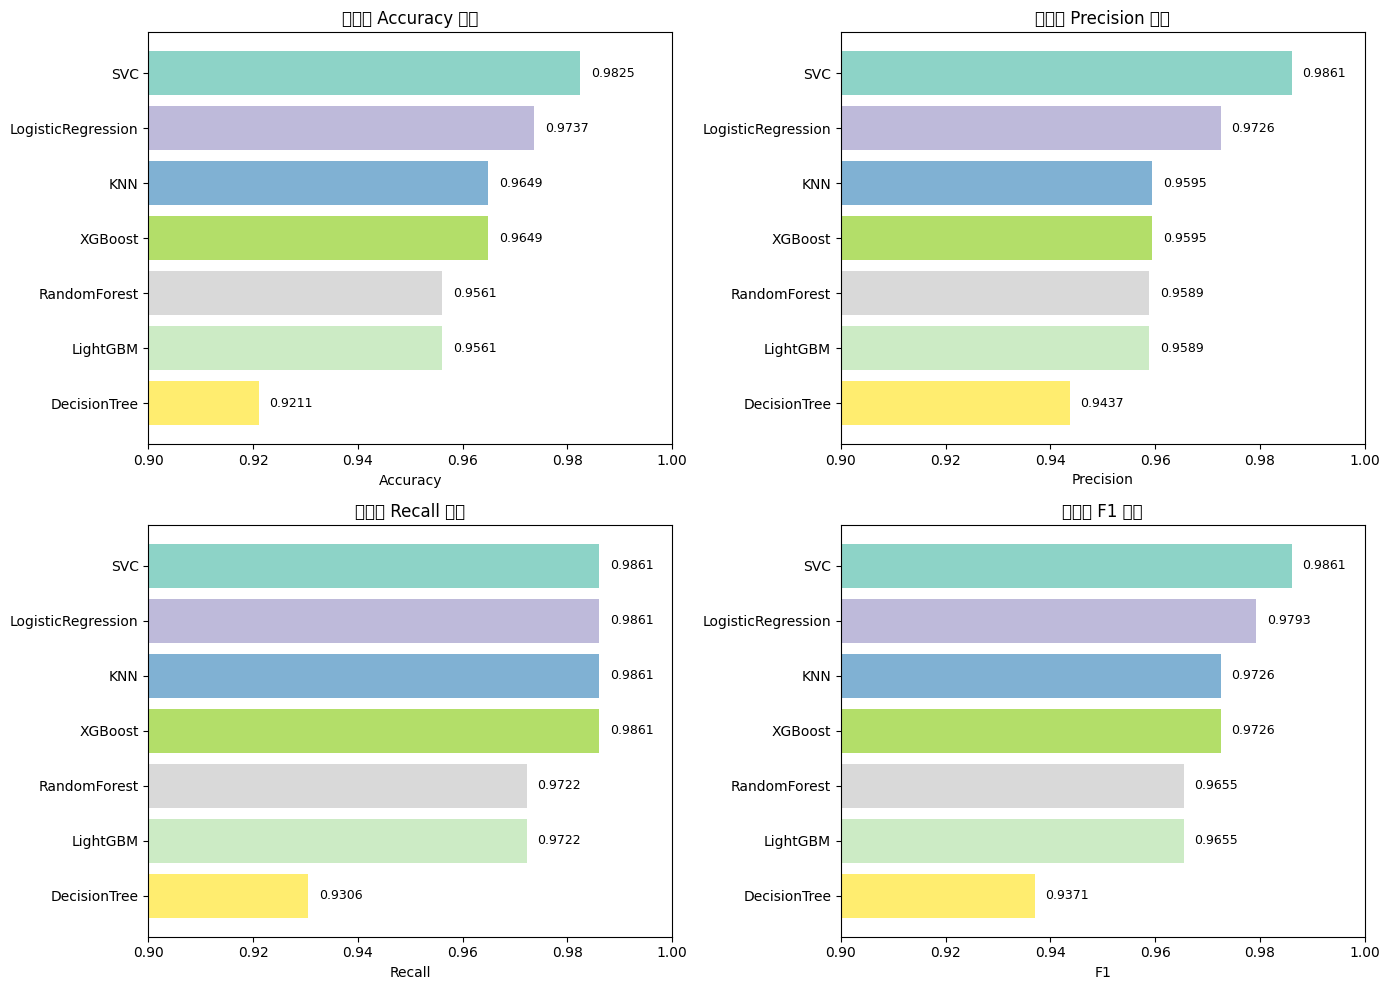

In [22]:
# 성능 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
colors = plt.cm.Set3(np.linspace(0, 1, len(results_sorted)))

for ax, metric in zip(axes.flatten(), metrics):
    bars = ax.barh(results_sorted['Model'], results_sorted[metric], color=colors)
    ax.set_xlabel(metric)
    ax.set_title(f'모델별 {metric} 비교')
    ax.set_xlim([0.9, 1.0])
    ax.invert_yaxis()
    
    for i, v in enumerate(results_sorted[metric]):
        ax.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 11. 혼동 행렬 비교

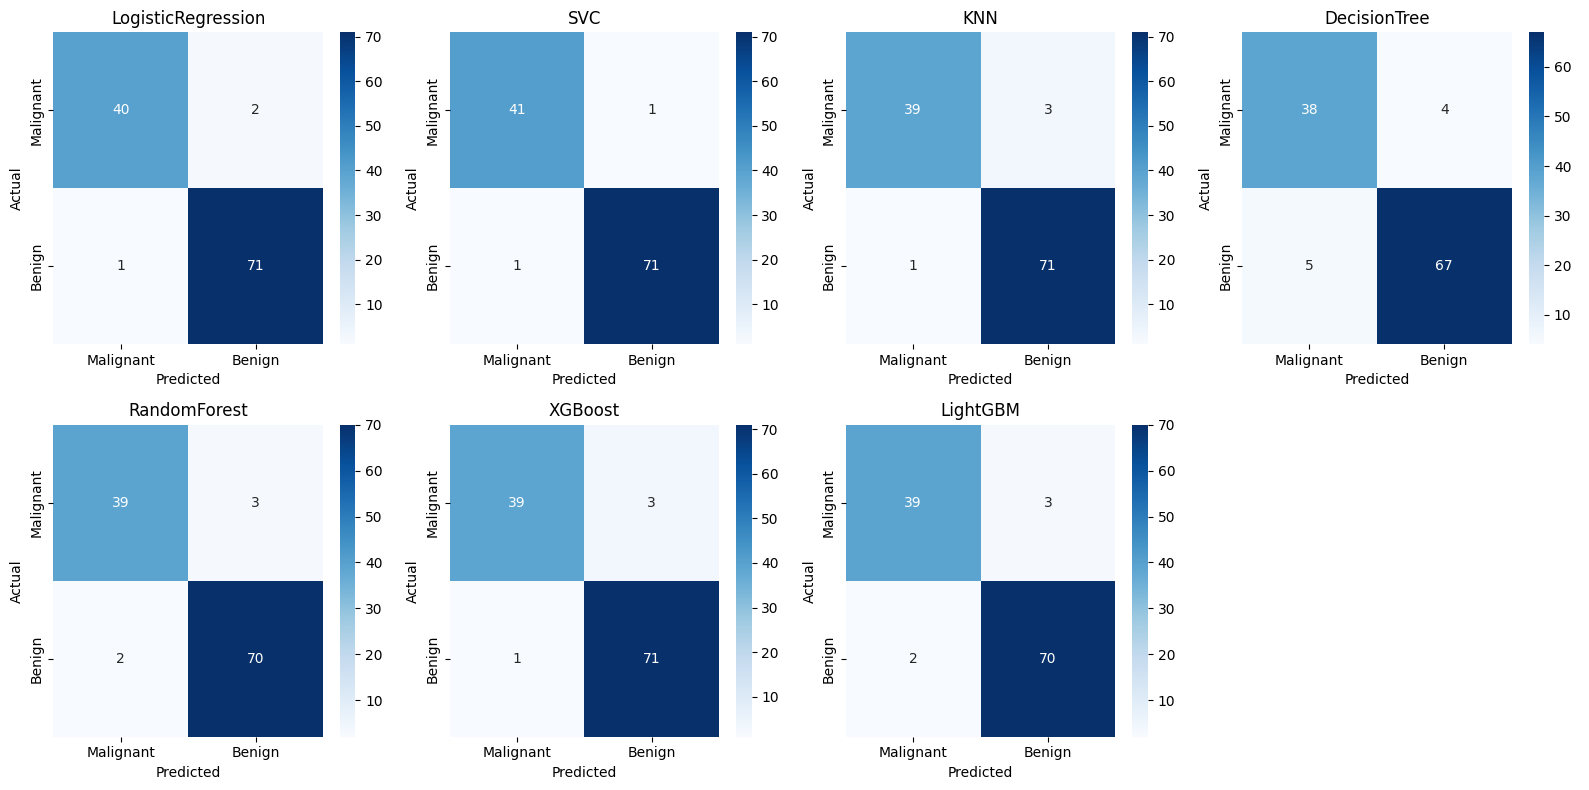

In [23]:
# 상위 4개 모델의 혼동 행렬 시각화
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

models_preds = [
    ('LogisticRegression', pred_lr),
    ('SVC', pred_svc),
    ('KNN', pred_knn),
    ('DecisionTree', pred_dt),
    ('RandomForest', pred_rf),
    ('XGBoost', pred_xgb),
    ('LightGBM', pred_lgbm)
]

# 상위 모델 선택 (axes 개수에 맞춤)
for ax, (name, pred) in zip(axes.flatten()[:len(models_preds)], models_preds):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'])
    ax.set_title(f'{name}')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

# 빈 axes 숨기기
for ax in axes.flatten()[len(models_preds):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## 12. ROC Curve 비교

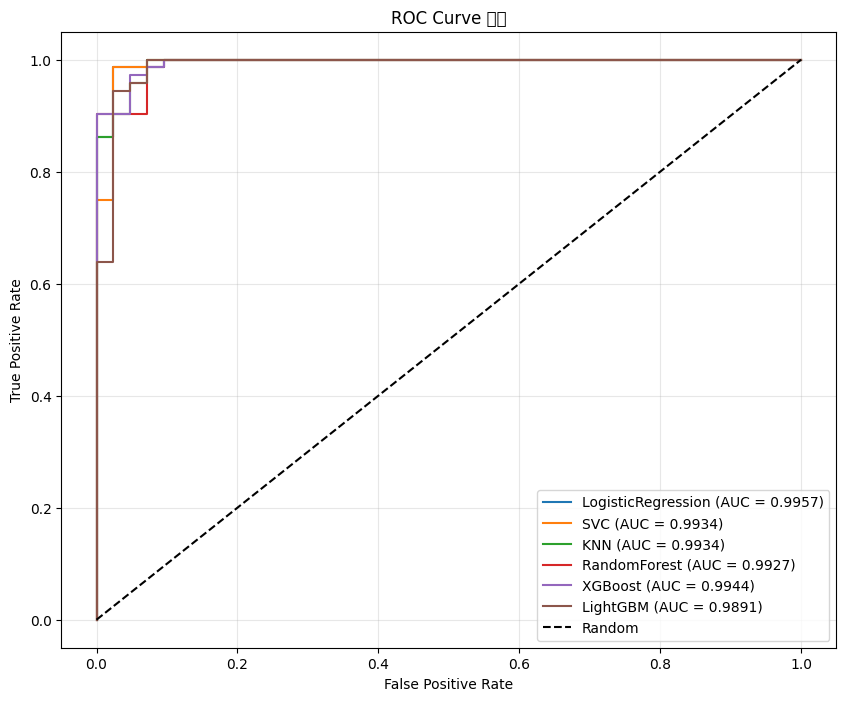

In [24]:
# ROC Curve 비교
plt.figure(figsize=(10, 8))

models_for_roc = [
    ('LogisticRegression', best_lr),
    ('SVC', best_svc),
    ('KNN', best_knn),
    ('RandomForest', best_rf),
    ('XGBoost', best_xgb),
    ('LightGBM', best_lgbm)
]

for name, model in models_for_roc:
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve 비교')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## 13. 파라미터 중요도 분석

In [25]:
!pip install plotly

In [26]:
!pip install --upgrade nbformat

In [27]:
# XGBoost 파라미터 중요도
fig = optuna.visualization.plot_param_importances(study_xgb)
fig.update_layout(title='XGBoost 파라미터 중요도')
fig.show()

In [28]:
# LightGBM 파라미터 중요도
fig = optuna.visualization.plot_param_importances(study_lgbm)
fig.update_layout(title='LightGBM 파라미터 중요도')
fig.show()

## 14. 최적 파라미터 요약

In [29]:
print("=" * 70)
print("최적화된 하이퍼파라미터 요약")
print("=" * 70)

all_studies = [
    ('LogisticRegression', study_lr),
    ('SVC', study_svc),
    ('KNN', study_knn),
    ('DecisionTree', study_dt),
    ('RandomForest', study_rf),
    ('XGBoost', study_xgb),
    ('LightGBM', study_lgbm)
]

for name, study in all_studies:
    print(f"\n[{name}]")
    print(f"  최적 F1 (CV): {study.best_value:.4f}")
    for param, value in study.best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.6f}")
        else:
            print(f"  {param}: {value}")

최적화된 하이퍼파라미터 요약

[LogisticRegression]
  최적 F1 (CV): 0.9878
  C: 0.123386
  penalty: l2

[SVC]
  최적 F1 (CV): 0.9828
  kernel: linear
  C: 0.071424

[KNN]
  최적 F1 (CV): 0.9757
  n_neighbors: 10
  weights: distance
  metric: minkowski

[DecisionTree]
  최적 F1 (CV): 0.9489
  max_depth: 6
  min_samples_split: 14
  min_samples_leaf: 4
  criterion: gini

[RandomForest]
  최적 F1 (CV): 0.9702
  n_estimators: 290
  max_depth: 7
  min_samples_split: 3
  min_samples_leaf: 1
  max_features: log2

[XGBoost]
  최적 F1 (CV): 0.9807
  n_estimators: 102
  learning_rate: 0.054624
  max_depth: 7
  min_child_weight: 2
  subsample: 0.883204
  colsample_bytree: 0.682253
  reg_alpha: 0.002601
  reg_lambda: 0.054946

[LightGBM]
  최적 F1 (CV): 0.9807
  n_estimators: 293
  learning_rate: 0.291470
  max_depth: 5
  num_leaves: 84
  min_child_samples: 64
  subsample: 0.727192
  colsample_bytree: 0.760028
  reg_alpha: 0.001291
  reg_lambda: 0.505313


In [30]:
# 최고 성능 모델
best_model_row = results_sorted.iloc[0]

print("\n" + "=" * 70)
print("최고 성능 모델")
print("=" * 70)
print(f"모델: {best_model_row['Model']}")
print(f"Accuracy:  {best_model_row['Accuracy']:.4f}")
print(f"Precision: {best_model_row['Precision']:.4f}")
print(f"Recall:    {best_model_row['Recall']:.4f}")
print(f"F1-score:  {best_model_row['F1']:.4f}")
print(f"AUC:       {best_model_row['AUC']:.4f}")


최고 성능 모델
모델: SVC
Accuracy:  0.9825
Precision: 0.9861
Recall:    0.9861
F1-score:  0.9861
AUC:       0.9934


## 15. 결론

### Optuna를 사용한 분류 모델 최적화 요약

| 모델 유형 | 모델 | 주요 튜닝 파라미터 |
|----------|------|--------------------|
| **기본** | LogisticRegression | C, penalty |
| **기본** | SVC | C, kernel, gamma |
| **기본** | KNN | n_neighbors, weights, metric |
| **기본** | DecisionTree | max_depth, min_samples_split, criterion |
| **앙상블** | RandomForest | n_estimators, max_depth, max_features |
| **앙상블** | XGBoost | learning_rate, max_depth, reg_alpha/lambda |
| **앙상블** | LightGBM | learning_rate, num_leaves, min_child_samples |

### 분류 문제에서의 Optuna 활용 팁

1. **평가 지표 선택**: F1-score는 불균형 데이터에서 유용, 균형 데이터는 Accuracy도 가능
2. **Stratified K-Fold**: 클래스 비율을 유지하면서 교차 검증
3. **로그 스케일 탐색**: C, learning_rate, regularization 파라미터에 효과적
4. **조건부 파라미터**: SVC의 kernel에 따라 gamma, degree 조건부 설정

### 참고 자료
- [Optuna 공식 문서](https://optuna.readthedocs.io/)
- [Scikit-learn 분류 가이드](https://scikit-learn.org/stable/supervised_learning.html)